## CPU inference time

'\nSpyder Editor\n\nThis is a temporary script file.\n'

Destination Folder: /home/pengmiao/Project/MEMSYS/Pem/data/output/notebooks/03_1/
['swaptions_1_1M.out', 'swaptions_2_1M.out', 'swaptions_1_repeat_1M.out']
{}
Skipping EDA report generation
USE_GPU: False
Executing Scenario LSTM_FPGA_Pretrained_rerun_1_Swaptions_1_1m
Running for 400000
Tokenizing ...
Raw Vocabulary Size: 89114
Quantile based Minimum Frequency for 1 is 0
0 399999 0 199999 0 200000
Max Accuracy: 1.0
Total Removals: 0
Pruned Vocabulary Size: 58630
Final Vocabulary Size: 58630
Total Sequences: 399996
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3, 10)             586300    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0       

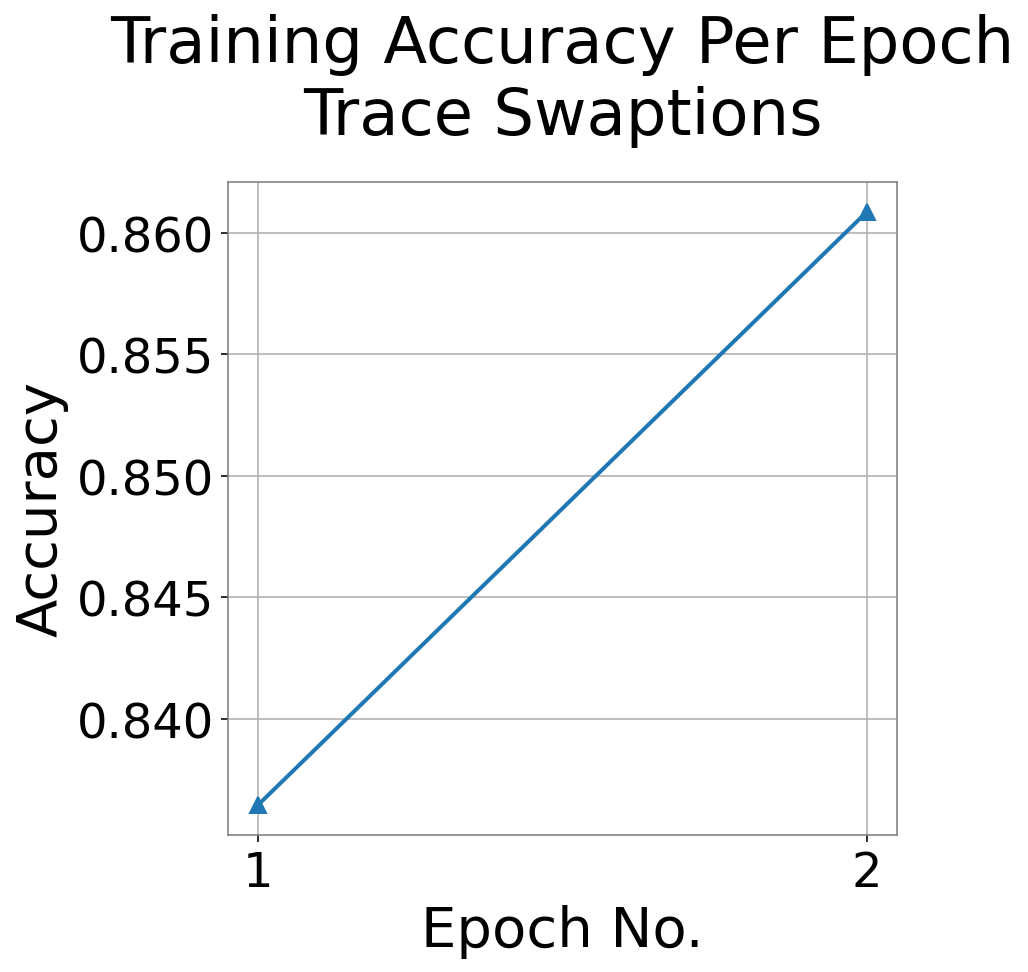

Train Accuracy 0.860853, Test Accuracy 0.241647


<DictProxy object, typeid 'dict' at 0x7fe546d80b70>

Executing Scenario LSTM_FPGA_Pretrained_new_1_Swaptions_1_1m
Running for 400000
Tokenizing ...
Raw Vocabulary Size: 89115
Quantile based Minimum Frequency for 1 is 0
0 399999 0 199999 0 200000
Max Accuracy: 1.0
Total Removals: 0
Pruned Vocabulary Size: 58631
Final Vocabulary Size: 58631
Total Sequences: 399996
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3, 10)             586310    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
Total params: 588,310
Trainable params: 588,310
Non-trainable params: 0


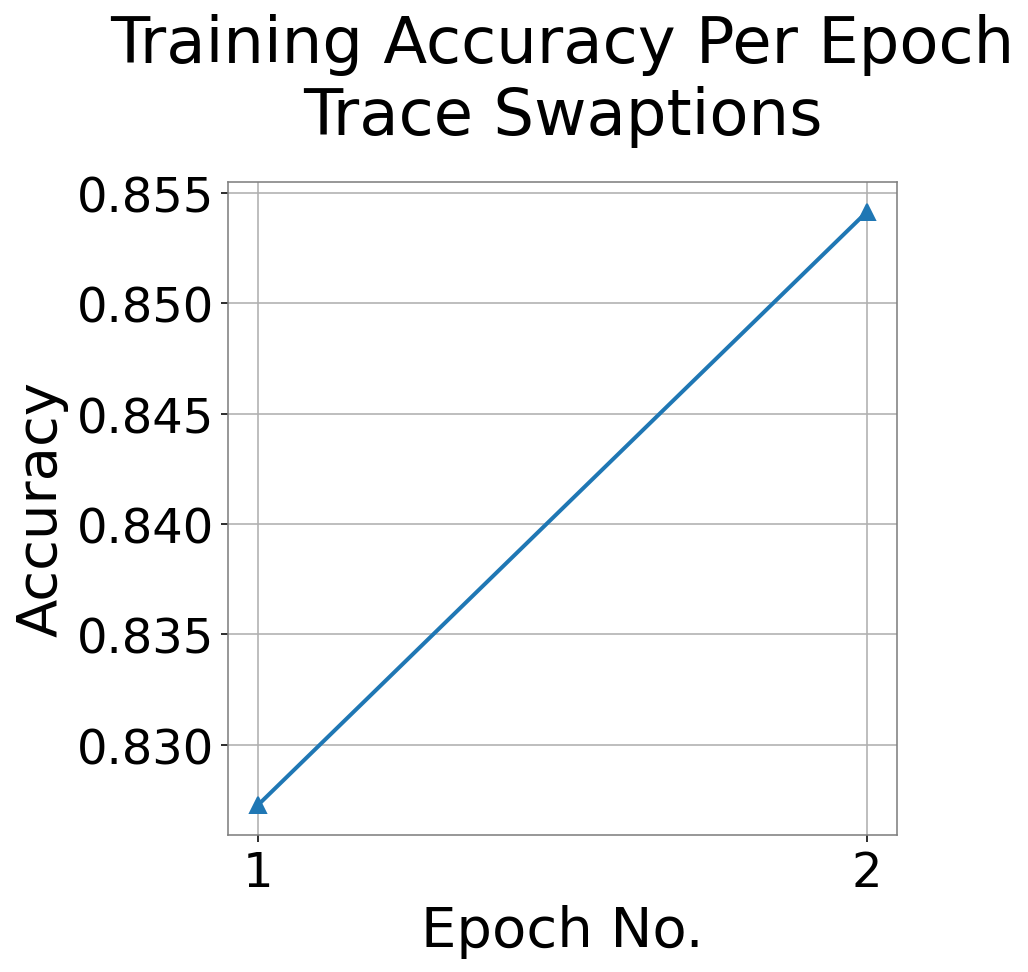

Train Accuracy 0.854134, Test Accuracy 0.215342


<DictProxy object, typeid 'dict' at 0x7fe546d80b70>

In [3]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
%matplotlib inline
import sys
from utils import *
X=[]

if platform.system() == "Linux":
    PROJECT_ROOT_DIRECTORY = "/home/pengmiao/Project/MEMSYS/Pem/"#"/home/aggelos/projects/SDH/"
    sys.path.append(PROJECT_ROOT_DIRECTORY)
    os.environ["TMP"] = "/tmp"
    USE_GPU = False#True
else:
    PROJECT_ROOT_DIRECTORY = "E:/Lab/PyCharm/Pem_MEMSYS_try3/Anglos/"
    sys.path.append(PROJECT_ROOT_DIRECTORY)
    USE_GPU = False

DELETE_OLD_RESULTS = False

NUMBER_OF_PROCESSES = 2

PERFORM_EDA = False

NOTEBOOK_ID = "03_1"

README_TXT = """# README
## Ensemble modeling of memory access timeseries (using shapelets, LSTMs and more)
"""
###

# Inputs:
# TRACE_DIRECTORY = PROJECT_ROOT_DIRECTORY + "data/input/"
#TRACE_DIRECTORY = "E:/Lab/PyCharm/Pem_MEMSYS_try3/Anglos/data/"
TRACE_DIRECTORY ="/home/pengmiao/Project/MEMSYS/data/"
TRACE_FILE_NAMES = [
    'swaptions_1_1M.out'
]  # more to be added here

# Size of files in number of rows. This should be implemented as a single dict for both
TRACE_FILE_NAME_SIZES = {
    # "swaptions_mem.out": 66999281,
    # "blackscholes_mem.out": 63141878,
    # "fluidanimate_mem.out": 838028424

    #'blackscholes_1.out': 63141878,
    'swaptions_1_1M.out': 1000000

}
###

# Outputs:
NOTEBOOK_ROOT_DIRECTORY = PROJECT_ROOT_DIRECTORY + "data/output/notebooks/%s/" % NOTEBOOK_ID

NOTEBOOK_PLOTS_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "figs/"

NOTEBOOK_DATA_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "data/"

NOTEBOOK_PICKLES_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "pickles/"

NOTEBOOK_REPORT_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "reports/"

###

CURRENT_TIMESTAMP = get_current_timestamp()
setup_report(data_dir=NOTEBOOK_ROOT_DIRECTORY, readme_text=README_TXT, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_PLOTS_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_DATA_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_PICKLES_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_REPORT_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
set_plot_style_for_paper()

print("Destination Folder: %s" % NOTEBOOK_ROOT_DIRECTORY)
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

# this code adds also the variations of each primary trace, namely the ones with _2 and 1_rerun prefix.
TRACE_FILE_NAMES_AND_VARIATIONS = []
for trace in TRACE_FILE_NAMES:
    if "old" not in trace:
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace)
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace.replace("1_1M", "2_1M"))
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace.replace("1_1M.out", "1_repeat_1M.out"))
    else:
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace)
print(TRACE_FILE_NAMES_AND_VARIATIONS)

# In[]
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, Sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Embedding
from keras.utils import plot_model
from keras.models import load_model, save_model
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from sys import getsizeof
import statsmodels.api as sm
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Manager
from collections import Counter
from numpy import argmax
from sklearn.metrics import accuracy_score
matplotlib.rcParams['text.usetex'] = False #True
import time
#from tensorflow.contrib.rnn import *

if USE_GPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 , 'CPU': 8} )
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)

    sess = tf.compat.v1.Session(config=config)
    #set_session(sess)
    tf.compat.v1.keras.backend.set_session(sess)
    print(tf.test.gpu_device_name())

# In[] Data Preprocessing Functions
def convert_to_binary(data=None, bit_size=16):
    """
    Input: an array of integers
    Returns a numpy array of arrays where each number is represented with a list of its binary digits
    IMPORTANT: Currently 16 bit conversion is implemented below. For difference sizes, change 16 to something else.
    """
    if bit_size == 16:
        dataset = np.array([[int(d) for d in str('{0:016b}'.format(x))] for x in list(data)])
    elif bit_size == 32 or bit_size not in [16, 32]:
        if bit_size != 32:
            print
            "Using 32bits delta representation"
        dataset = np.array([[int(d) for d in str('{0:032b}'.format(x))] for x in list(data)])
    # print "A10", dataset[:10]
    return dataset


def difference(dataset, interval=1):
    """
    Calculates the difference between a time-series and a lagged version of it
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


def difference16(data=None, lag=1, prune_lsb=False, prune_length=None):
    """
    Calculates the difference between a time-series and a lagged version of it that are represented in HEX format.
    This can be used to convert memory addresses to integers.
    """
    diff = list()
    for i in range(lag, len(data)):
        if prune_lsb:
            value = int(data[i][:-prune_length] + '0' * prune_length, 16) - int(
                data[i - lag][:-prune_length] + '0' * prune_length, 16)
        else:
            value = int(data[i], 16) - int(data[i - lag], 16)
        diff.append(value)
    return diff


def inverse_difference(last_ob, value):
    """
    Reconstructs the next value of a differenced time series.
    """
    return value + last_ob

# In[] Plot Configuration
params = {
    'axes.labelsize': 28,
    'font.size': 24,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'text.usetex': False, #True,
    #'figure.figsize': [4.5, 4.5],
    'figure.facecolor': 'w',
    'figure.edgecolor': 'w',
    'axes.facecolor': 'w',
    'axes.edgecolor': 'gray',
    'savefig.facecolor': 'w',
    'savefig.edgecolor': 'g',
    'savefig.pad_inches': 0.1,
    'savefig.transparent': True,
    'axes.titlepad': 24,
    'axes.titlesize': 32
}
rcParams.update(params)

# In[] Perform EDA

# PERFORM_EDA = False
NROWS = 500000

manager = Manager()


def run_eda(dataset=None, app_name=None, manual_encoding=False, decompose_timeseries=False, file_suffix=None):
    set_plot_size(8, 8)

    file_name_suffix = ("tok_seq" if not manual_encoding else "manual_enc_seq") + (
        "_decomposed" if decompose_timeseries else "") + (
                                   "_%s_%s.eps" % (app_name.replace(" ", "_"), file_suffix)).replace("-", "_").replace(
        " ", "_").lower()
    report_name_prefix = ("Of Mem Deltas  " if decompose_timeseries else "") + (
        "" if not manual_encoding else "Of Manually")

    #     if not manual_encoding:
    #         tokenizer = Tokenizer()
    #         tokenizer.fit_on_texts(list(dataset))
    #         encoded_all = tokenizer.texts_to_sequences([' '.join(list(dataset))])[0]
    #     else:
    #         encoded_all = encode_mem_accesses(list(dataset)) # angelos version
    # TODO: cleanup code here since we are now passing deltas
    encoded_all = dataset  # its already delta
    if decompose_timeseries:
        # decomposition implements diff for now

        # encoded_all = get_timeseries_decomposition(data=encoded_all, frequency=decomposition_freq, plot=True, file_name_suffix=file_name_suffix, app_name=app_name, report_name_prefix=report_name_prefix)[2]
        # encoded_all = [x for x in encoded_all if str(x) != 'nan']
        encoded_all = difference(encoded_all, 1)

    set_plot_size(16, 5)
    _ = plt.figure()
    # _ = pd.DataFrame(encoded_all, columns=["address"]).plot(linewidth=1, fontsize=22)
    _ = plt.plot(encoded_all, marker='x', markersize=8, linestyle='None')
    _ = plt.ylim([-50000, 50000])
    _ = plt.title("Memory Delta Time-Series %s\nFor Trace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address Delta")
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "raw_ts_pruned_%s" % (file_name_suffix.replace(".eps", "png")),
                    bbox_inches='tight')
    _ = plt.show(block=False)
    set_plot_size(8, 8)


def eda_worker(dataset, app_name, file_suffix):
    """
    Implements the main call that generates data for Experimental Data Analysis (EDA)
    """
    run_eda(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=False,
            file_suffix=file_suffix)

# In[] Perform Time Series Shapelet Analysis
rcParams['agg.path.chunksize'] = 10000

# PERFORM_EDA = False
NROWS = 10000

NCHUNKS = 2
SKIP_ROWS = 1000

manager = Manager()

# shapelet_report = manager.dict()
shapelet_report = {}  # This nested dictionary cannot be implemented with multiprocesses bc its not mutable. So we fall back to using signle processes


def run_shape_analyzer(dataset=None, app_name=None, manual_encoding=False, decompose_timeseries=False, chunk_id=None):
    global shapelet_report
    set_plot_size(30, 6)

    encoded_all = dataset
    file_name_suffix = ("tok_seq" if not manual_encoding else "manual_enc_seq") + (
        "_decomposed" if decompose_timeseries else "") + ("%s_%s.png" % (chunk_id, app_name.replace(" ", "_"))).replace(
        "-", "_").replace(" ", "_").lower()
    report_name_prefix = ("Of Mem Deltas  " if decompose_timeseries else "") + (
        "" if not manual_encoding else "Of Manually")

    report_id = "%s_%s_%s" % (app_name, manual_encoding, decompose_timeseries)
    report_name = app_name.replace(" ", "")
    params = {
        "manual_enconding": manual_encoding,
        "decompose_timeseries": decompose_timeseries
    }

    if report_id not in shapelet_report.keys():
        shapelet_report[report_id] = {
            "report_name": report_name,
            "params": params,
            "plots": {
                "movavg": {},
                "rawts": {},
                "diffts": {},
                "rollacf": {},
                "acfts": {}
            }
        }
    filename = NOTEBOOK_PLOTS_DIRECTORY + "mov_avg_%s" % (file_name_suffix)
    print(filename)
    print(encoded_all[:100])

    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).rolling(1000).mean().plot(linewidth=1, fontsize=22)
    _ = plt.title("Moving Average %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Average Memory Address")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["movavg"][chunk_id] = filename

    filename = NOTEBOOK_PLOTS_DIRECTORY + "raw_ts_%s" % (file_name_suffix)
    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).plot(linewidth=1, fontsize=22)
    _ = plt.title("Raw Time-Series %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["rawts"][chunk_id] = filename

    # TODO: make this diff to be done directly on the MEM addresses (HEX)
    filename = NOTEBOOK_PLOTS_DIRECTORY + "diff_ts_%s" % (file_name_suffix)
    # _ = pd.DataFrame(encoded_all, columns=["address"]).diff().plot(linewidth=1, fontsize=22)
    # _ = pd.DataFrame(pd.DataFrame(encoded_all, columns=["address"]).diff(), columns=["address"]).rolling(1000).mean().plot(linewidth=1, fontsize=22)
    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).diff().plot(linewidth=1, fontsize=22)
    _ = plt.title("Delta Time-Series %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address Deltas")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["diffts"][chunk_id] = filename


def trace_shape_analyzer_worker(dataset, app_name, chunk_id):
    """
    Implements the main call that generates data for Experimental Data Analysis (EDA)
    """
    run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=False,
                       chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=True, chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=True, manual_encoding=False, chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=True, manual_encoding=True, chunk_id=chunk_id)


chunk = 0
word_index = 1
encoding_dictionary = defaultdict(int)

print(dict(shapelet_report))


# In[] Process Report
def create_html_report(config, report_name):
    page = []
    page.append("""<html>
    <head>
    <title>SDH Report</title>
    </head>
    <body>""")

    # page.append('<ul>\n')

    for report_id, val in config.iteritems():
        print(report_id)
        page.append("<h1>%s</h1>" % report_id.replace("_False_False", ""))
        page.append("""
            <table style="width:100%">
              <tr>
                <th width="10%">Metric Name</th>
                <th width="90%">Plot</th>
              </tr>
        """)
        for k, v in val["plots"].iteritems():
            print(k, v)
            for kk, vv in v.iteritems():
                page.append('<tr><td>Chunk # %s of %s </td>' % (kk, k))
                page.append('<td><img src="%s"></td></tr>' % vv)

        page.append('</table>\n')
    page.append('</body></html>')

    with open(NOTEBOOK_REPORT_DIRECTORY + report_name + ".html", "w") as text_file:
        text_file.write('\n'.join(page))


if len(shapelet_report) > 0:
    create_html_report(dict(shapelet_report), "shapelet")
else:
    print("Skipping EDA report generation")


# In[] Modeling Functions
def precision(y_true, y_pred):
    """Precision metric. Only computes a batch-wise average of precision.
-    Computes the precision, a metric for multi-label classification of
-    how many selected items are relevant.
-    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
-    Only computes a batch-wise average of recall.
-    Computes the recall, a metric for multi-label classification of
-    how many relevant items are selected.
-    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
-    The F score is the weighted harmonic mean of precision and recall.
-    Here it is only computed as a batch-wise average, not globally.
-    This is useful for multi-label classification, where input samples can be
-    classified as sets of labels. By only using accuracy (precision) a model
-    would achieve a perfect score by simply assigning every class to every
-    input. In order to avoid this, a metric should penalize incorrect class
-    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
-    computes this, as a weighted mean of the proportion of correct class
-    assignments vs. the proportion of incorrect class assignments.
-    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
-    correct classes becomes more important, and with beta > 1 the metric is
-    instead weighted towards penalizing incorrect class assignments.
-    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

        # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)


def encode_mem_accesses(data):
    """
    It implements a mapping between a set of strings to integers.
    It does not have a limit in the max_dictionary_size supported.

    data: data input should be in Pandas DF format
    """
    tmp = defaultdict(int)
    i = 1
    encoded = []
    for el in list(data):
        if not tmp[el]:
            # if el not in tmp.keys():
            tmp[el] = i
            i += 1
        encoded.append(tmp[el])
    return encoded


def create_windowed_dataset(data, look_back):
    """
    Create the dataset by grouping windows of memory accesses together (using the look_back parameter)

    data: it should be a list of integers
    """
    sequences = list()
    for i in range(look_back, len(data)):
        sequence = data[i - look_back:i + 1]
        sequences.append(sequence)
    return sequences


def get_timeseries_decomposition(data=None, frequency=None, plot=False, report_name_prefix=None, file_name_suffix=None,
                                 app_name=None):
    # TODO: reimplement this
    """
    data is a list of integers which is converted to address - date dataframe
    """
    dta = pd.DataFrame(data)
    dta['date'] = dta.index
    dta.columns = ["address", "date"]

    dta['date'] = pd.DatetimeIndex(dta.date)  # ,  format="%Y-%m-%d %H:%M:%S")
    # df.index = pd.to_datetime(df.index, unit='s')
    # dta.address.interpolate(inplace=True)
    dta.set_index('date', inplace=True)

    # dta = dta.groupby(pd.TimeGrouper('%ss' % 1), as_index=True)['total'].sum()
    res = sm.tsa.seasonal_decompose(dta, freq=frequency, model='additive')
    if plot:
        _ = plt.figure()
        _ = res.plot()
        _ = plt.title(
            "Time Series Decomposition Of %s Tokenized Sequence For Trace %s" % (report_name_prefix, app_name))
        _ = plt.grid(True)
        _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "hist_%s" % (file_name_suffix), bbox_inches='tight')
        _ = plt.show(block=False)

    return list(res.trend['address']), list(res.seasonal['address']), list(res.resid['address'])


def plot_generic_timeseries(train_data=None,test_data=None, rows=2000, app_name="", scenario_name=None):
    set_plot_size(30, 4)
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    _ = plt.figure()
    _ = plt.plot(train_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Training Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_training_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    _ = plt.figure()
    _ = plt.plot(test_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Testing Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_testing_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_memory_trace(train_data=None, test_data=None, rows=2000, app_name="", scenario_name=None):
    set_plot_size(30, 4)
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    _ = plt.figure()
    _ = plt.plot(train_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Training Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_training_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    _ = plt.figure()
    _ = plt.plot(test_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Testing Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_testing_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_on_the_fly_model_performance(history=None, app_name="", scenario_name=None):
    # TODO: optimize function and remove key accesses from the dictionaries (pass them as params)
    # Plot training & validation accuracy values
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    set_plot_size(6, 6)
    _ = plt.figure()
    _ = plt.plot(range(1, len(history.history['acc']) + 1), history.history['acc'], linestyle='-', marker='^',
                 markersize=8, linewidth=2)
    _ = plt.plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'], linestyle='-', marker='s',
                 markersize=8, linewidth=2)
    _ = plt.title('Model Accuracy For Trace %s\nScenario %s' % (app_name, scenario_name))
    _ = plt.ylabel('Accuracy')
    _ = plt.xlabel('Epoch No.')
    _ = plt.grid(True)
    _ = plt.legend(['Train', 'Test'], loc='upper left')
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_test_accuracy_for_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    # Plot training & validation loss values
    _ = plt.figure()
    _ = plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle='-', marker='^',
                 markersize=8, linewidth=2)
    _ = plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle='-', marker='s',
                 markersize=8, linewidth=2)
    _ = plt.title('Model Loss For Trace %s\nScenario %s' % (app_name, scenario_name))
    _ = plt.ylabel('Loss')
    _ = plt.xlabel('Epoch No.')
    _ = plt.grid(True)
    _ = plt.legend(['Train', 'Test'], loc='upper left')
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_test_loss_for_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_train_test_model_performance(train_history=None, test_history=None, app_name="", scenario_name=None):
    # TODO: optimize function and remove key accesses from the dictionaries (pass them as params)
    if train_history is not None:
        print('Final Training accuracy: %s' % (train_history.history['accuracy'][-1]))
        print('Test score: %s' % test_history[0])
        print('Test accuracy: %s' % test_history[1])
        scenario_name = scenario_name.replace("_", "-").replace(" ", "-")
        data = train_history.history['accuracy']
        set_plot_size(6, 6)
        _ = plt.figure()
        _ = plt.plot(range(1, len(data) + 1), data, linestyle='-', marker='^', markersize=8, linewidth=2)
        _ = plt.xticks(range(1, len(data) + 1))
        _ = plt.title('Training Accuracy Per Epoch\nTrace %s' % (app_name))
        _ = plt.ylabel('Accuracy')
        _ = plt.xlabel('Epoch No.')
        _ = plt.grid(True)
        # _ = plt.legend(['Train'], loc='upper left')
        _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_and_test_accuracy_for_%s_%s.eps" % (app_name, scenario_name),
                        bbox_inches='tight')
        _ = plt.show(block=False)


def approx_entropy(U, m, r):
    try:
        U = np.array(U)

        def _maxdist(x_i, x_j):
            return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

        def _phi(m):
            x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
            C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
            return (N - m + 1.0) ** (-1) * sum(np.log(C))

        N = len(U)
        return abs(_phi(m + 1) - _phi(m))
    except:
        print(U)
        raise


def sample_entropy(data):
    p_data = pd.Series(data).value_counts() / len(data)  # calculates the probabilities
    entropy = sc.stats.entropy(p_data)  # input probabilities to get the entropy
    return entropy

# In[] LSTM Model Implementation
def dataset_creator(scenario):
    use_manual_encoding = scenario['use_manual_encoding']
    app_name = scenario['app_name']
    decompose_timeseries = scenario['decompose_timeseries']
    decomposition_frequency = scenario['decomposition_frequency']
    test_ratio = scenario['test_ratio']
    on_the_fly_testing = scenario['on_the_fly_testing']
    plot_timeseries = scenario['plot_timeseries']
    look_back = scenario['look_back_window']
    scenario_name = scenario['scenario_name']
    vocabulary_maximum_size = scenario['vocabulary_maximum_size']
    vocabulary_mimimum_word_frequency_quantile = scenario['vocabulary_mimimum_word_frequency_quantile']
    model_diffs = scenario['model_diffs']
    lstm_batch_size = scenario['lstm_batch_size']
    lstm_epochs = scenario['lstm_epochs']
    verbosity = scenario['verbosity']
    dropout_ratio = scenario['dropout_ratio']
    lstm_size = scenario['lstm_size']
    embedding_size = scenario['embedding_size']
    prediction_batch_size = scenario['prediction_batch_size']
    online_retraining = scenario['online_retraining']
    online_learning_accuracy_threshold = scenario['online_learning_accuracy_threshold']
    online_retraining_periods = scenario['online_retraining_periods']
    online_retraining_period_size = scenario['online_retraining_period_size']
    number_of_rows_to_model = scenario['number_of_rows_to_model']
    number_of_rows_to_skip = scenario['number_of_rows_to_skip']
    keep_read_access_only = scenario['keep_read_access_only']
    prune_lsb = scenario['prune_lsb']
    prune_length = scenario['prune_length']
    pretrain_type = scenario["pretrain_type"]
    bit_size = scenario["bit_size"]
    convert_output_to_binary = scenario['convert_output_to_binary']  # this is used for FPGA implementation.

    max_test_accuracy = 1
    # used to reduce accuracy appropriatelly in case of rounding/approximations in the prediction address.

    tokenizer = None
    tokenizer2 = None

    # This is used to represent rare words and not get encoded individually, which then will be
    # flagged as false positives (or negatives) and use them to reduce the model accuracy
    # All the rare words will be encoded with the following value.
    dummy_word = "0xffffffff"
    dummy_word_index = -1  # this is the index of the dummy word (to be set later)

    # this is to be used to spoof the index of the dummy word and thus force false positive
    # determination during testing (since these words cannot be predicted)
    dummy_index = -1

    # Set total rows to None to load all the rows for online learning. Else keep as many as we need.
    total_rows = scenario['number_of_rows_to_model'] if not online_retraining else \
        scenario['number_of_rows_to_model'] + online_retraining_period_size * (online_retraining_periods + 2)
    print("Running for %d" % total_rows)

    if pretrain_type is None:
        dataset_verbose = pd.read_csv(TRACE_DIRECTORY + scenario['trace_file_name'], sep=" ", nrows=total_rows,
                                      skiprows=scenario['number_of_rows_to_skip'])
    else:
        ### This implements testing with a pretrained model
        # TODO: put this info about the rerun files at the begining of the script as a dictionary.
        comparison_file_name = scenario['trace_file_name']
        if pretrain_type == "rerun":
            comparison_file_name = comparison_file_name.replace("_1M.out", "") + "_repeat_1M.out"
        if pretrain_type == "new":
            comparison_file_name = comparison_file_name.replace("1_", "2_")
        ###

        #dataset_verbose1 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name, sep=" ",
        #                               nrows=int(math.floor(total_rows / 2.0)),
        #                               skiprows=scenario['number_of_rows_to_skip'])
        dataset_verbose1 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name,sep=" ",
                                       nrows=int(math.floor(total_rows / 2.0)),
                                       skiprows=scenario['number_of_rows_to_skip'])
        #dataset_verbose1.columns = ["instruction", "address"]
        #print(dataset_verbose1)
        dataset_verbose1.columns = ["instruction", "type", "address"]
        #Pem
       # dataset_verbose1.columns = ["address"]

        #dataset_verbose2 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name, sep=" ",
        #                               nrows=int(math.ceil(total_rows / 2.0)),
        #                               skiprows=scenario['number_of_rows_to_skip'] + int(math.floor(total_rows / 2.0)))
        dataset_verbose2 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name,sep=" ",
                                       nrows=int(math.ceil(total_rows / 2.0)),
                                       skiprows=scenario['number_of_rows_to_skip'] + int(math.floor(total_rows / 2.0)))
        #dataset_verbose2.columns = ["instruction", "address"]
        # Pem
        dataset_verbose2.columns = ["instruction", "type", "address"]

        dataset_verbose = dataset_verbose1.append(dataset_verbose2, ignore_index=True)


    dataset_verbose.columns = ["instruction", "type", "address"]
    if keep_read_access_only:
        dataset_verbose = dataset_verbose[dataset_verbose["type"] == "R"]
    # print dataset_verbose.head()
    # print dataset_verbose.describe()

    dataset = dataset_verbose['address']
    del dataset_verbose

    if not use_manual_encoding:
        if model_diffs:
            print("Tokenizing ...")
            # Tokenize raw memory address to convert them to integers
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(list(dataset))
            concat_dataset = [' '.join(list(dataset))]
            # This is used only for plotting purposes
            encoded_raw = tokenizer.texts_to_sequences(concat_dataset)[0]

            vocab_size_raw = len(tokenizer.word_index) + 1
            print('Raw Vocabulary Size: %d' % vocab_size_raw)

            # calculate diffs of integer memory addresses
            # print dataset

            encoded_raw_diff = difference16(data=list(dataset), lag=1, prune_lsb=prune_lsb, prune_length=prune_length)

            encoded_raw_diff_str = ["%s%d" % ("1x" if x < 0 else "0x", abs(x)) for x in encoded_raw_diff]
            df = pd.DataFrame(encoded_raw_diff_str)
            # print df

            df.columns = ['delta']

            df2 = pd.DataFrame(pd.Series(encoded_raw_diff_str).value_counts())
            # print "Length2 %s" % len(df2.index)
            df2.columns = ['total']
            df2['delta'] = df2.index
            # print "xxxxx", df2
            df2 = df2.reset_index(drop=True)
            df2.columns = ['total', 'delta']
            # print "V2", df2
            bit_size_offset = 3

            df2_2 = df2[['total']].copy()
            df2_2['cumsum'] = df2_2.sort_values(by="total", ascending=False)[['total']].cumsum(axis=0)

            tmp_total_rows = df2['total'].sum()

            # Get the row index where the cumulative quantity reaches half the total.
            # print "AAA44", tmp_total_rows, df2_2.head()
            df2_3 = df2_2[df2_2['cumsum'] < vocabulary_mimimum_word_frequency_quantile * tmp_total_rows]  # .idxmax()
            # print "AAA34", myindex, tmp_total_rows
            # print df2_2.head()

            # Get the price at that index
            vocabulary_mimimum_word_frequency = df2_3.loc[
                df2_3['cumsum'].idxmax(), 'total']  # int(list(df2_2['total'].iloc[myindex])[0])

            if vocabulary_mimimum_word_frequency == 1:
                vocabulary_mimimum_word_frequency = 0  # since 1 is going to prune a lot of words
            print("Quantile based Minimum Frequency for %s is %s" % (
            vocabulary_mimimum_word_frequency_quantile, vocabulary_mimimum_word_frequency))
            # df2 = df2[df2['total'] > vocabulary_mimimum_word_frequency]
            # print "xxxxxxx", df2.head()

            # print "xxxxx", df2.head()

            if vocabulary_maximum_size and not convert_output_to_binary:
                df2 = df2[(df2.index > vocabulary_maximum_size) | (
                            df2['total'] < vocabulary_mimimum_word_frequency)]  # TODO: make it <=
            else:
                df2 = df2[(df2.index > math.pow(2, bit_size) - bit_size_offset) | (df2[
                                                                                       'total'] < vocabulary_mimimum_word_frequency)]  # we subtract words to allow for the dummy word to be also stored.

            # print "xxxxx", df2.head()

            # vocabulary_mimimum_word_frequency = np.quantile(encode_mem_accesses(list(encoded_raw_diff_str)), vocabulary_mimimum_word_frequency_quantile) # angelos version  , vocabulary_mimimum_word_frequency_quantile)

            # Set a dummy value to represent the ignored deltas. This will be converted later to a unique integer using a second tokenizer.
            # print "Length2 %s" % len(df2.index)
            df.loc[df.delta.isin(df2.delta), ['delta']] = dummy_word

            # print "xxxxxx", df[df['delta'] == dummy_word]
            # print "Length1 %s" % len(df.index)

            # print df.head()
            # print df[df['delta'] == dummy_word]
            # df.describe()
            encoded_raw_diff_pruned = df['delta']
            # print "AAA3", encoded_raw_diff_pruned.head()
            # print "V3"
            # print encoded_raw_diff_pruned.head()

            # print "pruned", encoded_raw_diff_pruned[:300]
            del df, df2

            # Calclulate accuracy reduction due to vocabulary pruning.
            tmp_train, tmp_test = train_test_split(encoded_raw_diff_pruned, test_size=test_ratio, shuffle=False)
            total_removals = Counter(encoded_raw_diff_pruned)[dummy_word]
            total_rows = len(encoded_raw_diff_pruned)
            train_removals = Counter(tmp_train)[dummy_word]
            train_total = len(tmp_train)
            test_removals = Counter(tmp_test)[dummy_word]
            test_total = len(tmp_test)
            print(total_removals, total_rows, train_removals, train_total, test_removals, test_total)
            max_test_accuracy = 1 - test_removals / test_total
            print("Max Accuracy: %s" % max_test_accuracy)
            print("Total Removals: %s" % total_removals)

            # Tokenize again the pruned differentials to produce unique vocabulary (classes)
            encoded_raw_diff_pruned_str = [str(x) for x in list(encoded_raw_diff_pruned)]
            tokenizer2 = Tokenizer()
            tokenizer2.fit_on_texts(encoded_raw_diff_pruned_str)
            encoded_final = tokenizer2.texts_to_sequences([' '.join(encoded_raw_diff_pruned_str)])[0]
            final_vocab_size = len(tokenizer2.word_index) + 1
            print('Pruned Vocabulary Size: %d' % final_vocab_size)

            for word, index in tokenizer2.word_index.items():
                if word == dummy_word:
                    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%", word, index)
                    dummy_word_index = index
                    break
        #             set_plot_size(6,6)
        #             _ = plt.hist(encoded_final, bins=100)
        #             _ = plt.grid(True)
        #             _ = plt.title("Histogram Of All Memory Deltas After Prunning\nFor The %s App" % app_name)
        #             _ = plt.show()

        else:
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(list(dataset))
            encoded_final = tokenizer.texts_to_sequences([' '.join(list(dataset))])[0]
            final_vocab_size = len(tokenizer.word_index) + 1
    else:
        # TODO: move this in the diff section or remove completely.
        encoded_final = encode_mem_accesses(list(dataset))  # angelos version
        final_vocab_size = len(set(encoded_final)) + 1

    if decompose_timeseries:
        # TODO: this is incomplete. Either fix or remove completely.
        dataset = get_timeseries_decomposition(encoded_final, decomposition_frequency)[
            2]  # TODO add back in the predictions the trend and seasonality
        final_vocab_size = len(set(dataset)) + 1

    # The series below are for visulaization purposes only.
    if plot_timeseries:
        if model_diffs:
            encoded_raw_train, encoded_raw_test = train_test_split(encoded_raw, test_size=test_ratio, shuffle=False)
            encoded_raw_diff_train, encoded_raw_diff_test = train_test_split(encoded_raw_diff, test_size=test_ratio,
                                                                             shuffle=False)
            plot_memory_trace(train_data=encoded_raw_train, test_data=encoded_raw_test, rows=200000, app_name=app_name,
                              scenario_name=scenario_name + " Raw")
            plot_memory_trace(train_data=encoded_raw_diff_train, test_data=encoded_raw_diff_test, rows=200000,
                              app_name=app_name, scenario_name=scenario_name + " Raw Diff")

        encoded_train, encoded_test = train_test_split(encoded_final, test_size=test_ratio, shuffle=False)
        plot_memory_trace(train_data=encoded_train, test_data=encoded_test, rows=2000, app_name=app_name,
                          scenario_name=scenario_name + " Final")

    sequences = create_windowed_dataset(encoded_final, look_back)

    print('Final Vocabulary Size: %d' % final_vocab_size)
    print('Total Sequences: %d' % len(sequences))

    # Pad the sequences to the same length (is not really needed here since we have fixed input windows).
    # See documentation in the source code here: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/sequence.py
    max_length = max([len(seq) for seq in sequences])
    sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

    # print encoded_final, sequences, final_vocab_size

    return encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, dummy_word_index, dummy_index, vocab_size_raw

# In[] Define LSTM model
def run_lstm_model(scenario=None):
    """
    Encode the sequence of memory addresses to a sequence of integers
    We can do it either using Keras, or by implementing our own convertion function (see above "encode_mem_accesses")
    For the Keras approach, see documentation in the source code here: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/text.py
    """

    use_manual_encoding = scenario['use_manual_encoding']
    app_name = scenario['app_name']
    decompose_timeseries = scenario['decompose_timeseries']
    decomposition_frequency = scenario['decomposition_frequency']
    test_ratio = scenario['test_ratio']
    on_the_fly_testing = scenario['on_the_fly_testing']
    plot_timeseries = scenario['plot_timeseries']
    look_back = scenario['look_back_window']
    scenario_name = scenario['scenario_name']
    vocabulary_maximum_size = scenario['vocabulary_maximum_size']
    vocabulary_mimimum_word_frequency_quantile = scenario['vocabulary_mimimum_word_frequency_quantile']
    model_diffs = scenario['model_diffs']
    lstm_batch_size = scenario['lstm_batch_size']
    lstm_epochs = scenario['lstm_epochs']
    verbosity = scenario['verbosity']
    dropout_ratio = scenario['dropout_ratio']
    lstm_size = scenario['lstm_size']
    embedding_size = scenario['embedding_size']
    prediction_batch_size = scenario['prediction_batch_size']
    online_retraining = scenario['online_retraining']
    online_learning_accuracy_threshold = scenario['online_learning_accuracy_threshold']
    online_retraining_periods = scenario['online_retraining_periods']
    online_retraining_period_size = scenario['online_retraining_period_size']
    number_of_rows_to_model = scenario['number_of_rows_to_model']
    model_type = scenario['model_type']
    loss_function = scenario['loss_function']
    activation_fuction = scenario['activation_function']
    convert_output_to_binary = scenario['convert_output_to_binary']  # this is used for FPGA implementation.
    bit_size = scenario['bit_size']
    load_existing_pickles = scenario['load_existing_pickles']
    unique_key = abs(hash(frozenset(scenario.items())))

    misc_stats = {}

    start_time = time.time()

    if online_retraining:
        """
        This implements the online training/testing/retraining cyble of SDH project.
        """
        retraining_period_counter = 1

        # =====================================================================================================
        # Data preparation
        # =====================================================================================================
        encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, dummy_word_index, dummy_index,\
        vocab_size_raw = dataset_creator(scenario)
        # =====================================================================================================

        # =====================================================================================================
        # Neural Network Configuration
        # =====================================================================================================
        if convert_output_to_binary:
            # print final_vocab_size, embedding_size, max_length-1
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))
            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(bit_size,
                            activation=activation_fuction))  # the size of this layer should align with the size of the bit representation of the output.
            model.compile(loss=loss_function, optimizer='adam', metrics=[
                'accuracy'])  # top_k_categorical_accuracy is still wrong but we have it for illustration purposes.
        else:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))

            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(final_vocab_size, activation=activation_fuction))
            model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

        if verbosity > 0:
            print(model.summary())
        SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))
        plot_model(model, to_file=NOTEBOOK_PLOTS_DIRECTORY + 'model_for_%s.png' % scenario_name, show_shapes=True,
                   show_layer_names=False)
        # =====================================================================================================

        # =====================================================================================================
        # Model training/testing
        # =====================================================================================================

        X, y = sequences[:, :-1], sequences[:, -1]
        # print "A4", sequences
        # Vectorize the output y (one hot encoding)
        if convert_output_to_binary:
            y = convert_to_binary(data=y, bit_size=bit_size)  # converts diffs to 16 bit representation
        else:
            y = to_categorical(y, num_classes=final_vocab_size)
        # print "A5", y
        period_online_learning_accuracy = []
        period_online_learning_accuracy_avg = 0

        overall_online_learning_accuracy = []  # tracks the time series of accuracy overall (never reset)
        overall_retrain_tracker = []  # tracks when retrain happens for plotting purposes

        # X = np.array([np.array(tmp_x) for tmp_x in X])
        # y = np.matrix([np.array(tmp_y) for tmp_y in y])
        # y = np.asarray(y, dtype=int)

        X_train, X_test = train_test_split(X, train_size=number_of_rows_to_model,
                                           test_size=online_retraining_period_size, shuffle=False)
        
        y_train, y_test = train_test_split(y, train_size=number_of_rows_to_model,
                                           test_size=online_retraining_period_size, shuffle=False)

        # y_train = np.array([np.array(x) for x in y_train])#np.array(y_train).reshape(len(y_train), 16)
        # y_test = np.array([np.array(x) for x in y_test]) #np.asanyarray(y_test).reshape(len(y_train), 16)
        # print "A1", y_train, y_test, y

        # =====================================================================================================
        # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
        if max_test_accuracy < 1:
            print("Overwritting Ignored Words...")
            print(dummy_word_index)
            if convert_output_to_binary:
                y_test = np.array([[0 for tmp2 in tmp1] if all(
                    tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in
                                   y_test])
            else:
                y_test = np.array(
                    [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
            print("Overwritting Ignored Words Completted")
        # =====================================================================================================

        while retraining_period_counter <= online_retraining_periods:
            # Train the model either the first time or if the accuracy deteriorates
            if retraining_period_counter == 1 or period_online_learning_accuracy_avg < online_learning_accuracy_threshold:
                print("Retraining after %d periods" % len(period_online_learning_accuracy))
                model_file_name = NOTEBOOK_PICKLES_DIRECTORY + "%s_retrain_at_period_%s_%s_8.h5" % (
                scenario_name, retraining_period_counter, unique_key)

                if load_existing_pickles and os.path.isfile(model_file_name):
                    model = load_model(model_file_name)
                    train_history = None
                    train_accuracy = -1  # train_history.history['acc'][-1]
                else:
                    train_history = model.fit(X_train,
                                              y_train,
                                              epochs=lstm_epochs,
                                              verbose=verbosity,
                                              shuffle=False,
                                              batch_size=lstm_batch_size)

                    model.save(model_file_name)
                    train_accuracy = train_history.history['accuracy'][-1]
                    period_online_learning_accuracy = []  # reset stats for the new period
                    overall_retrain_tracker.append(1)
            else:
                overall_retrain_tracker.append(0)

            if convert_output_to_binary:
                time_s=time.time()
                y_pred = model.predict([1,1,1])
                print("time:",time.time()-time_s)
                print("1X_test:",X_test)

                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0

                accuracy = accuracy_score(np.array(y_test), np.array(y_pred))

                aaaaa = np.packbits(np.array(y_test, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)

                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), aaaaa, delimiter=',',
                           fmt='%10.5f')
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), bbbbb, delimiter=',',
                           fmt='%10.5f')

            else:
                test_history = model.evaluate(X_test,
                                              y_test,
                                              batch_size=prediction_batch_size,
                                              verbose=verbosity)
                print("X_test:",X_test)
                accuracy = test_history[1]

            period_online_learning_accuracy.append(accuracy)
            period_online_learning_accuracy_avg = np.array([period_online_learning_accuracy]).mean()
            overall_online_learning_accuracy.append(accuracy)
            print("Overall Online Accuracy", overall_online_learning_accuracy)

            retraining_period_counter += 1
            # print "A3", y, (retraining_period_counter-1)*online_retraining_period_size, y.shape
            X_train, X_test = train_test_split(X[(retraining_period_counter - 1) * online_retraining_period_size:, :],
                                               train_size=number_of_rows_to_model,
                                               test_size=online_retraining_period_size, shuffle=False)
            y_train, y_test = train_test_split(y[(retraining_period_counter - 1) * online_retraining_period_size:, :],
                                               train_size=number_of_rows_to_model,
                                               test_size=online_retraining_period_size, shuffle=False)

            y_train = np.asanyarray(y_train)
            y_test = np.asanyarray(y_test)

            # =====================================================================================================
            # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
            if max_test_accuracy < 1:
                print("Overwritting Ignored Words...")
                print(dummy_word_index)
                if convert_output_to_binary:
                    y_test = np.array([[0 for tmp2 in tmp1] if all(
                        tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in
                                       y_test])
                else:
                    y_test = np.array(
                        [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
                print("Overwritting Ignored Words Completted")
            # =====================================================================================================

        # plot the online learning/retraining graph only at the end.
        if len(overall_online_learning_accuracy) > 1:
            set_plot_size(20, 8)
            _ = plt.figure()
            _ = plt.plot(range(1, len(overall_online_learning_accuracy) + 1), overall_online_learning_accuracy,
                         linestyle='-', marker='^', markersize=8, linewidth=2)

            for index, val in enumerate(overall_retrain_tracker):
                if val == 1 and index > 0:
                    # we don't flag as retraining the beginning of the testing phase
                    _ = plt.annotate('retrained', fontsize=22, xy=(index + 1, overall_online_learning_accuracy[index]),
                                     xytext=(index + 1.15, overall_online_learning_accuracy[index] + 0.15),
                                     arrowprops=dict(facecolor='black', arrowstyle="->"))

            _ = plt.title("Online Testing Accuracy Over Time\nFor The %s App" % (app_name))
            _ = plt.xlabel("Program Execution")
            _ = plt.ylabel("Accuracy")
            # _ = plt.legend(['Accuracy'], loc='upper left')
            _ = plt.ylim(0, 1.2)
            _ = plt.xlim(0.5, len(overall_online_learning_accuracy) + 0.5)
            _ = plt.grid(True)
            _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "online_accuracy_%s.eps" % (scenario_name), bbox_inches='tight')
            _ = plt.show(block=False)

        # TODO: fix to return average of all
        np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                   np.array([overall_online_learning_accuracy]), delimiter=',', fmt='%10.5f')
        np.savetxt('%s/online_retraining_tracker_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                   np.array([overall_retrain_tracker]), delimiter=',', fmt='%10.5f')

        misc_stats['execution_time'] = time.time() - start_time
        misc_stats['vocab_size_raw'] = vocab_size_raw
        misc_stats['final_vocab_size'] = final_vocab_size
        misc_stats['params'] = model.count_params()
        misc_stats['max_test_accuracy'] = max_test_accuracy

        return train_history.history['accuracy'][-1], np.array(
            overall_online_learning_accuracy).mean(), misc_stats  # test_history[1]

        # print "Train Accuracy %f, Test Accuracy %f" % (train_accuracy, accuracy)
        # return train_accuracy, accuracy, misc_stats

    else:
        # =====================================================================================================
        # Data preparation
        # =====================================================================================================
        encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, \
        dummy_word_index, dummy_index, vocab_size_raw = dataset_creator(
            scenario)
        # =====================================================================================================

        # =====================================================================================================
        # Neural Network Configuration
        # =====================================================================================================
        if convert_output_to_binary:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))
            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(bit_size,
                            activation=activation_fuction))  # the size of this layer should align with the size of the bit representation of the output.
            model.compile(loss=loss_function, optimizer='adam', metrics=[
                'accuracy'])  # top_k_categorical_accuracy is still wrong but we have it for illustration purposes.
        else:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))

            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(final_vocab_size, activation=activation_fuction))
            model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

        if verbosity > 0:
            print(model.summary())
        SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))
        plot_model(model, to_file=NOTEBOOK_PLOTS_DIRECTORY + 'model_for_%s.png' % scenario_name, show_shapes=True,
                   show_layer_names=False)
        # =====================================================================================================

        # =====================================================================================================
        # Model training/testing
        # =====================================================================================================
        X, y = sequences[:, :-1], sequences[:, -1]
        # print X.shape, y.shape
        # print "A11", y
        # y = y.reshape((16, len(y)))

        # print "A7", sequences
        # Vectorize the output y (one hot encoding)
        if convert_output_to_binary:
            y = convert_to_binary(data=y, bit_size=bit_size)  # converts diffs to 16 bit representation
        else:
            y = to_categorical(y, num_classes=final_vocab_size)

        # print y
        # y = np.array([np.array(tmp_y) for tmp_y in y])
        # y = y.reshape((y.shape[0], 16))
        # print X.shape, y.shape
        # print "A8", y.reshape(1, -1)

        if on_the_fly_testing:
            # TODO: fix the portion used for y_test to account for the pruned vocabulary
            history = model.fit(X,
                                y,
                                validation_split=test_ratio,
                                epochs=lstm_epochs,
                                batch_size=lstm_batch_size,
                                verbose=verbosity,
                                shuffle=False)

            save_obj(directory=NOTEBOOK_PICKLES_DIRECTORY, obj=model, name="%s_on_the_fly_testing" % (scenario_name))
            plot_on_the_fly_model_performance(history, app_name=app_name, scenario_name=scenario_name)

            # TODO: fix max accuracy multiplier to be done automatically
            np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                       np.array([history.history['val_acc'][-1] * max_test_accuracy]), delimiter=',', fmt='%10.5f')
            return history.history['accuracy'][-1] * max_test_accuracy, history.history['val_acc'][
                -1] * max_test_accuracy, misc_stats

        else:
            X_train, X_test = train_test_split(X, test_size=test_ratio, shuffle=False)
            y_train, y_test = train_test_split(y, test_size=test_ratio, shuffle=False)
            # print "A2", y_train, y_test, y
            # print X, X_train, X_test
            # print y, y_train, y_test

            # =====================================================================================================
            # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
            if max_test_accuracy < 1:
                print("Overwritting Ignored Words...")
                print(dummy_word_index)
                if convert_output_to_binary:
                    # print "AA2", y_test
                    # for el in y_test:
                    # print "AA3", el
                    # print convert_to_binary(data=[dummy_word_index], bit_size=bit_size)
                    # break
                    # print pd.DataFrame(y_test).describe()
                    # y_test = np.array([[0 for tmp2 in tmp1] if all(tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in y_test])
                    y_test = np.array([[0 for tmp2 in tmp1] if np.array_equal(tmp1,
                                                                              convert_to_binary(data=[dummy_word_index],
                                                                                                bit_size=bit_size)[
                                                                                  0]) else tmp1 for tmp1 in y_test])

                else:
                    y_test = np.array(
                        [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
                print("Overwritting Ignored Words Completted")
            # =====================================================================================================
            # print X_train, y_train
            model_file_name = NOTEBOOK_PICKLES_DIRECTORY + "%s_train_test_split_%s_128.h5" % (scenario_name, unique_key)

            if load_existing_pickles and os.path.isfile(model_file_name):
                model = load_model(model_file_name)
                train_history = None
                train_accuracy = -1  # train_history.history['acc'][-1]
            else:
                train_history = model.fit(X_train,
                                          y_train,
                                          epochs=lstm_epochs,
                                          verbose=verbosity,
                                          shuffle=False,
                                          batch_size=lstm_batch_size)

                model.save(model_file_name)
                train_accuracy = train_history.history['accuracy'][-1]

            if convert_output_to_binary:
                time_s=time.time()
                y_pred = model.predict(X_test)
                print("time:",time.time()-time_s)
                print("2X_test:",X_test)
                # np.savetxt('y_test1.txt', y_test, delimiter=',')
                # np.savetxt('y_pred1.txt', y_pred, delimiter=',')

                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0

                # np.savetxt('y_test2.txt', y_test, delimiter=',')
                # np.savetxt('y_pred2.txt', y_pred, delimiter=',')

                aaaaa = np.packbits(np.array(y_test, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                # print "ANGELOS", scenario_name
                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), aaaaa, delimiter=',',
                           fmt='%10.5f')
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), bbbbb, delimiter=',',
                           fmt='%10.5f')

                #                 plt.plot(aaaaa)
                #                 plt.show()
                #                 plt.plot(bbbbb)
                #                 plt.title("Predictions vs Actual Data")
                #                 plt.show()

                accuracy = accuracy_score(np.array(y_test), np.array(y_pred))
                test_history = [0, accuracy]  # for backwards compatibility
            else:
                test_history = model.evaluate(X_test,
                                              y_test,
                                              batch_size=prediction_batch_size,
                                              verbose=verbosity)
                accuracy = test_history[1]
                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), [-1], delimiter=',',
                           fmt='%10.5f')  # too much data; cannot be exported for efficiency reasons
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), [-1], delimiter=',',
                           fmt='%10.5f')  # too much data; cannot be exported for efficiency reasons

            misc_stats['execution_time'] = time.time() - start_time
            misc_stats['vocab_size_raw'] = vocab_size_raw
            misc_stats['final_vocab_size'] = final_vocab_size
            misc_stats['params'] = model.count_params()
            misc_stats['max_test_accuracy'] = max_test_accuracy

            np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name), np.array([accuracy]),
                       delimiter=',', fmt='%10.5f')
            plot_train_test_model_performance(train_history, test_history, app_name=app_name,
                                              scenario_name=scenario_name)

            print("Train Accuracy %f, Test Accuracy %f" % (train_accuracy, accuracy))
            return train_accuracy, accuracy, misc_stats
            # =====================================================================================================

# In [] Customizations
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from keras.backend import epsilon
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import nn


def custom_cross_entropy(target, output, from_logits=False, axis=-1):
    target = target[:, :-4]
    output = output[:, :-4]

    if not from_logits:
        # transform back to logits
        epsilon_ = ops.convert_to_tensor(epsilon(), dtype=output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
        output = math_ops.log(output / (1 - output))
    return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

# In[] Model Evaluation Scenarios

#Important Notes

# Swaptions app needs a higher threshold for vocabulary capping. The best tried was 15. For the Blackscholes app we tried 5 and worked fine.

trace_offsets = {
    'swaptions_1_1M.out': 100000,
}

manager = Manager()

all_results = manager.dict()  # this is for sharing data across processes and also store the features data that will be used for clustering

modeling_scenarios = OrderedDict()


def lstm_modeling_worker(scenario):
    global all_results
    import json

    print("Executing Scenario %s" % scenario['scenario_name'])

    report_file_name = '%s/all_stats_%s_%s.json' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name, scenario['id'])

    if not scenario['skip_run_if_previous_stats_found'] or not os.path.isfile(report_file_name):
        train_history, test_history, misc_stats = run_lstm_model(scenario)
        all_results[scenario['scenario_name']] = [scenario, train_history, test_history, misc_stats]
        '''
        json = json.dumps(all_results[scenario['scenario_name']], indent=4)

        f = open(report_file_name, "w")
        f.write(json)
        f.close()'''
    else:
        print("Skipping run since past results found for the same configuration...")
    return all_results

# # 50/50 Split Analysis
for trace in TRACE_FILE_NAMES:
    if trace in [
        'swaptions_1_1M.out',
                 # 'swaptions_old_1_1M.out',
                 # 'blackscholes_old_1_1M.out',
                 # 'fluidanimate_old_1_1M.out'
                 ]:
        for model_type in ["fpga"]:  # "vanilla",  "custom_loss_fpga"
            for pretrain_type in ["rerun", "new"]:
                scenario_counter = 1
                trace_short = trace.split(".")[0].replace("_mem", "").capitalize()
                for i in range(5, 6):
                    # we store the scenario name as key, but also add it in the scenario configuration for availability in each function
                    modeling_scenarios['LSTM_%s_Pretrained_%s_%s_%s' % (
                        model_type.upper(), pretrain_type, scenario_counter, trace_short)] = {
                        # trace params
                        'scenario_name': 'LSTM_%s_Pretrained_%s_%s_%s' % (
                            model_type.upper(), pretrain_type, scenario_counter, trace_short),
                        'app_name': trace.split(".")[0].split("_")[0].capitalize(),
                        'trace_file_name': trace,
                        'load_existing_pickles': True,
                        'skip_run_if_previous_stats_found': True,

                        # dataset params
                        'keep_read_access_only': False,
                        'number_of_rows_to_model': 400000,
                        'number_of_rows_to_skip': trace_offsets[trace],  # int(TRACE_FILE_NAME_SIZES[trace]*3.0/5.0),
                        'pretrain_type': pretrain_type,

                        'model_diffs': True,
                        # set to True if you want instead of the actual time series to model memory location differences.
                        'vocabulary_maximum_size': 50000 if "vanilla" in model_type else 0,
                        # this is to further reduce the dictionary size
                        'vocabulary_mimimum_word_frequency_quantile': 0.95 if not "fpga" in model_type else 1,
                        "prune_lsb": True if "lsb" in model_type else False,
                        "prune_length": 1,
                        # this corresponds to how many "letters" to be pruned from the HEX address (1 letter = 4 bits)
                        "bit_size": 16,

                        # Not Used
                        'decompose_timeseries': False,  # not used #TODO: remove
                        'decomposition_frequency': 10,  # not used #TODO: remove
                        'use_manual_encoding': False,
                        # not used #TODO: remove # True applies only to non-diff time series. --TODO: remove completely.

                        # model params
                        'model_type': model_type,  # None, #'fpga',
                        'look_back_window': 3,
                        'lstm_epochs': 2,
                        'lstm_batch_size': 256,
                        'lstm_size': 16,
                        'dropout_ratio': 0.1,
                        'embedding_size': 10,
                        'verbosity': 1,
                        'test_ratio': 0.1 * float(i),  # this does not apply to online learning
                        'prediction_batch_size': 4096,  # this has an impact only if on_the_fly_testing is disabled
                        'loss_function': 'categorical_crossentropy' if not "fpga" in model_type else "binary_crossentropy" if model_type in [
                            "fpga", "lsb_fpga"] else custom_cross_entropy,
                        # 'categorical_crossentropy', 'binary_crossentropy', # custom_crossentropy,  # binary_cross_entropy is needed for multi-label classification, otherwise we need categorical_crossentropy
                        'activation_function': "softmax" if not "fpga" in model_type else "sigmoid",
                        'convert_output_to_binary': True if "fpga" in model_type else False,

                        # run-time params
                        'on_the_fly_testing': False,
                        # if True, it will run testing on the whole data for each epoch (good for plotting performance). Not used if online_retraining is enabled.
                        'plot_timeseries': False,

                        'online_retraining': False,
                        # if this is True, then we model number_of_rows_to_model samples and then generate predictions for until the accuracy becomes smaller than online_learning_accuracy_threshold, and then we retrain etc.
                        'online_learning_accuracy_threshold': 0.6,
                        # It is used only if online_retraining is set to True.
                        'online_retraining_periods': 5,  # It is used only if online_retraining is set to True.
                        'online_retraining_period_size': 10000,
                        # How many predictions to run before measuring cummulative accuracy for the given period. It is used only if online_retraining is set to True.
                    }
                    scenario_counter += 1

                # calculate a unique ID for each scenario based on its values
tmp_scenarios = modeling_scenarios.copy()
for scenario_name, scenario in tmp_scenarios.items():
    modeling_scenarios[scenario_name]['id'] = abs(hash(frozenset(scenario.items())))

print ("USE_GPU:",USE_GPU)
if not USE_GPU:
    # with ProcessPoolExecutor(max_workers=NUMBER_OF_PROCESSES) as e:
    for scenario_name, scenario in modeling_scenarios.items():
        # e.submit(lstm_modeling_worker, scenario)
        lstm_modeling_worker(scenario)
else:
    for scenario_name, scenario in modeling_scenarios.items():
        lstm_modeling_worker(scenario)




In [10]:
file_path="/home/pengmiao/Project/MEMSYS/Pem/data/output/notebooks/03_1/pickles/LSTM_FPGA_Pretrained_new_1_Swaptions_1_1m_train_test_split_5341913423611448998_16.h5"
model = load_model(file_path)
import time
x_p=np.array([[1,1,1]])
time_s=time.time()
y_p=model.predict(x_p)
time_e=time.time()
print("time:",time_e-time_s)
y_p

time: 0.3886730670928955


array([[1.22219324e-04, 3.09258699e-03, 7.03305006e-04, 5.17368317e-04,
        8.40455294e-04, 3.81946564e-04, 6.69538975e-04, 8.00669193e-04,
        1.45098567e-03, 9.53307748e-03, 1.14919245e-02, 2.27427483e-02,
        8.65122676e-03, 6.08502626e-02, 8.66370499e-02, 9.16935444e-01]],
      dtype=float32)

## GPU Inference time

In [ ]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
%matplotlib inline
import sys
from utils import *
X=[]

if platform.system() == "Linux":
    PROJECT_ROOT_DIRECTORY = "/home/pengmiao/Project/MEMSYS/Pem/"#"/home/aggelos/projects/SDH/"
    sys.path.append(PROJECT_ROOT_DIRECTORY)
    os.environ["TMP"] = "/tmp"
    USE_GPU = True
else:
    PROJECT_ROOT_DIRECTORY = "E:/Lab/PyCharm/Pem_MEMSYS_try3/Anglos/"
    sys.path.append(PROJECT_ROOT_DIRECTORY)
    USE_GPU = False

DELETE_OLD_RESULTS = False

NUMBER_OF_PROCESSES = 2

PERFORM_EDA = False

NOTEBOOK_ID = "03_1"

README_TXT = """# README
## Ensemble modeling of memory access timeseries (using shapelets, LSTMs and more)
"""
###

# Inputs:
# TRACE_DIRECTORY = PROJECT_ROOT_DIRECTORY + "data/input/"
#TRACE_DIRECTORY = "E:/Lab/PyCharm/Pem_MEMSYS_try3/Anglos/data/"
TRACE_DIRECTORY ="/home/pengmiao/Project/MEMSYS/data/"
TRACE_FILE_NAMES = [
    'swaptions_1_1M.out'
]  # more to be added here

# Size of files in number of rows. This should be implemented as a single dict for both
TRACE_FILE_NAME_SIZES = {
    # "swaptions_mem.out": 66999281,
    # "blackscholes_mem.out": 63141878,
    # "fluidanimate_mem.out": 838028424

    #'blackscholes_1.out': 63141878,
    'swaptions_1_1M.out': 1000000

}
###

# Outputs:
NOTEBOOK_ROOT_DIRECTORY = PROJECT_ROOT_DIRECTORY + "data/output/notebooks/%s/" % NOTEBOOK_ID

NOTEBOOK_PLOTS_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "figs/"

NOTEBOOK_DATA_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "data/"

NOTEBOOK_PICKLES_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "pickles/"

NOTEBOOK_REPORT_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "reports/"

###

CURRENT_TIMESTAMP = get_current_timestamp()
setup_report(data_dir=NOTEBOOK_ROOT_DIRECTORY, readme_text=README_TXT, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_PLOTS_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_DATA_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_PICKLES_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_REPORT_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
set_plot_style_for_paper()

print("Destination Folder: %s" % NOTEBOOK_ROOT_DIRECTORY)
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

# this code adds also the variations of each primary trace, namely the ones with _2 and 1_rerun prefix.
TRACE_FILE_NAMES_AND_VARIATIONS = []
for trace in TRACE_FILE_NAMES:
    if "old" not in trace:
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace)
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace.replace("1_1M", "2_1M"))
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace.replace("1_1M.out", "1_repeat_1M.out"))
    else:
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace)
print(TRACE_FILE_NAMES_AND_VARIATIONS)

# In[]
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, Sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Embedding
from keras.utils import plot_model
from keras.models import load_model, save_model
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from sys import getsizeof
import statsmodels.api as sm
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Manager
from collections import Counter
from numpy import argmax
from sklearn.metrics import accuracy_score
matplotlib.rcParams['text.usetex'] = False #True
import time
#from tensorflow.contrib.rnn import *

if USE_GPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 , 'CPU': 8} )
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)

    sess = tf.compat.v1.Session(config=config)
    #set_session(sess)
    tf.compat.v1.keras.backend.set_session(sess)
    print(tf.test.gpu_device_name())

# In[] Data Preprocessing Functions
def convert_to_binary(data=None, bit_size=16):
    """
    Input: an array of integers
    Returns a numpy array of arrays where each number is represented with a list of its binary digits
    IMPORTANT: Currently 16 bit conversion is implemented below. For difference sizes, change 16 to something else.
    """
    if bit_size == 16:
        dataset = np.array([[int(d) for d in str('{0:016b}'.format(x))] for x in list(data)])
    elif bit_size == 32 or bit_size not in [16, 32]:
        if bit_size != 32:
            print
            "Using 32bits delta representation"
        dataset = np.array([[int(d) for d in str('{0:032b}'.format(x))] for x in list(data)])
    # print "A10", dataset[:10]
    return dataset


def difference(dataset, interval=1):
    """
    Calculates the difference between a time-series and a lagged version of it
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


def difference16(data=None, lag=1, prune_lsb=False, prune_length=None):
    """
    Calculates the difference between a time-series and a lagged version of it that are represented in HEX format.
    This can be used to convert memory addresses to integers.
    """
    diff = list()
    for i in range(lag, len(data)):
        if prune_lsb:
            value = int(data[i][:-prune_length] + '0' * prune_length, 16) - int(
                data[i - lag][:-prune_length] + '0' * prune_length, 16)
        else:
            value = int(data[i], 16) - int(data[i - lag], 16)
        diff.append(value)
    return diff


def inverse_difference(last_ob, value):
    """
    Reconstructs the next value of a differenced time series.
    """
    return value + last_ob

# In[] Plot Configuration
params = {
    'axes.labelsize': 28,
    'font.size': 24,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'text.usetex': False, #True,
    #'figure.figsize': [4.5, 4.5],
    'figure.facecolor': 'w',
    'figure.edgecolor': 'w',
    'axes.facecolor': 'w',
    'axes.edgecolor': 'gray',
    'savefig.facecolor': 'w',
    'savefig.edgecolor': 'g',
    'savefig.pad_inches': 0.1,
    'savefig.transparent': True,
    'axes.titlepad': 24,
    'axes.titlesize': 32
}
rcParams.update(params)

# In[] Perform EDA

# PERFORM_EDA = False
NROWS = 500000

manager = Manager()


def run_eda(dataset=None, app_name=None, manual_encoding=False, decompose_timeseries=False, file_suffix=None):
    set_plot_size(8, 8)

    file_name_suffix = ("tok_seq" if not manual_encoding else "manual_enc_seq") + (
        "_decomposed" if decompose_timeseries else "") + (
                                   "_%s_%s.eps" % (app_name.replace(" ", "_"), file_suffix)).replace("-", "_").replace(
        " ", "_").lower()
    report_name_prefix = ("Of Mem Deltas  " if decompose_timeseries else "") + (
        "" if not manual_encoding else "Of Manually")

    #     if not manual_encoding:
    #         tokenizer = Tokenizer()
    #         tokenizer.fit_on_texts(list(dataset))
    #         encoded_all = tokenizer.texts_to_sequences([' '.join(list(dataset))])[0]
    #     else:
    #         encoded_all = encode_mem_accesses(list(dataset)) # angelos version
    # TODO: cleanup code here since we are now passing deltas
    encoded_all = dataset  # its already delta
    if decompose_timeseries:
        # decomposition implements diff for now

        # encoded_all = get_timeseries_decomposition(data=encoded_all, frequency=decomposition_freq, plot=True, file_name_suffix=file_name_suffix, app_name=app_name, report_name_prefix=report_name_prefix)[2]
        # encoded_all = [x for x in encoded_all if str(x) != 'nan']
        encoded_all = difference(encoded_all, 1)

    set_plot_size(16, 5)
    _ = plt.figure()
    # _ = pd.DataFrame(encoded_all, columns=["address"]).plot(linewidth=1, fontsize=22)
    _ = plt.plot(encoded_all, marker='x', markersize=8, linestyle='None')
    _ = plt.ylim([-50000, 50000])
    _ = plt.title("Memory Delta Time-Series %s\nFor Trace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address Delta")
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "raw_ts_pruned_%s" % (file_name_suffix.replace(".eps", "png")),
                    bbox_inches='tight')
    _ = plt.show(block=False)
    set_plot_size(8, 8)


def eda_worker(dataset, app_name, file_suffix):
    """
    Implements the main call that generates data for Experimental Data Analysis (EDA)
    """
    run_eda(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=False,
            file_suffix=file_suffix)

# In[] Perform Time Series Shapelet Analysis
rcParams['agg.path.chunksize'] = 10000

# PERFORM_EDA = False
NROWS = 10000

NCHUNKS = 2
SKIP_ROWS = 1000

manager = Manager()

# shapelet_report = manager.dict()
shapelet_report = {}  # This nested dictionary cannot be implemented with multiprocesses bc its not mutable. So we fall back to using signle processes


def run_shape_analyzer(dataset=None, app_name=None, manual_encoding=False, decompose_timeseries=False, chunk_id=None):
    global shapelet_report
    set_plot_size(30, 6)

    encoded_all = dataset
    file_name_suffix = ("tok_seq" if not manual_encoding else "manual_enc_seq") + (
        "_decomposed" if decompose_timeseries else "") + ("%s_%s.png" % (chunk_id, app_name.replace(" ", "_"))).replace(
        "-", "_").replace(" ", "_").lower()
    report_name_prefix = ("Of Mem Deltas  " if decompose_timeseries else "") + (
        "" if not manual_encoding else "Of Manually")

    report_id = "%s_%s_%s" % (app_name, manual_encoding, decompose_timeseries)
    report_name = app_name.replace(" ", "")
    params = {
        "manual_enconding": manual_encoding,
        "decompose_timeseries": decompose_timeseries
    }

    if report_id not in shapelet_report.keys():
        shapelet_report[report_id] = {
            "report_name": report_name,
            "params": params,
            "plots": {
                "movavg": {},
                "rawts": {},
                "diffts": {},
                "rollacf": {},
                "acfts": {}
            }
        }
    filename = NOTEBOOK_PLOTS_DIRECTORY + "mov_avg_%s" % (file_name_suffix)
    print(filename)
    print(encoded_all[:100])

    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).rolling(1000).mean().plot(linewidth=1, fontsize=22)
    _ = plt.title("Moving Average %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Average Memory Address")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["movavg"][chunk_id] = filename

    filename = NOTEBOOK_PLOTS_DIRECTORY + "raw_ts_%s" % (file_name_suffix)
    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).plot(linewidth=1, fontsize=22)
    _ = plt.title("Raw Time-Series %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["rawts"][chunk_id] = filename

    # TODO: make this diff to be done directly on the MEM addresses (HEX)
    filename = NOTEBOOK_PLOTS_DIRECTORY + "diff_ts_%s" % (file_name_suffix)
    # _ = pd.DataFrame(encoded_all, columns=["address"]).diff().plot(linewidth=1, fontsize=22)
    # _ = pd.DataFrame(pd.DataFrame(encoded_all, columns=["address"]).diff(), columns=["address"]).rolling(1000).mean().plot(linewidth=1, fontsize=22)
    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).diff().plot(linewidth=1, fontsize=22)
    _ = plt.title("Delta Time-Series %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address Deltas")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["diffts"][chunk_id] = filename


def trace_shape_analyzer_worker(dataset, app_name, chunk_id):
    """
    Implements the main call that generates data for Experimental Data Analysis (EDA)
    """
    run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=False,
                       chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=True, chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=True, manual_encoding=False, chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=True, manual_encoding=True, chunk_id=chunk_id)


chunk = 0
word_index = 1
encoding_dictionary = defaultdict(int)

print(dict(shapelet_report))


# In[] Process Report
def create_html_report(config, report_name):
    page = []
    page.append("""<html>
    <head>
    <title>SDH Report</title>
    </head>
    <body>""")

    # page.append('<ul>\n')

    for report_id, val in config.iteritems():
        print(report_id)
        page.append("<h1>%s</h1>" % report_id.replace("_False_False", ""))
        page.append("""
            <table style="width:100%">
              <tr>
                <th width="10%">Metric Name</th>
                <th width="90%">Plot</th>
              </tr>
        """)
        for k, v in val["plots"].iteritems():
            print(k, v)
            for kk, vv in v.iteritems():
                page.append('<tr><td>Chunk # %s of %s </td>' % (kk, k))
                page.append('<td><img src="%s"></td></tr>' % vv)

        page.append('</table>\n')
    page.append('</body></html>')

    with open(NOTEBOOK_REPORT_DIRECTORY + report_name + ".html", "w") as text_file:
        text_file.write('\n'.join(page))


if len(shapelet_report) > 0:
    create_html_report(dict(shapelet_report), "shapelet")
else:
    print("Skipping EDA report generation")


# In[] Modeling Functions
def precision(y_true, y_pred):
    """Precision metric. Only computes a batch-wise average of precision.
-    Computes the precision, a metric for multi-label classification of
-    how many selected items are relevant.
-    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
-    Only computes a batch-wise average of recall.
-    Computes the recall, a metric for multi-label classification of
-    how many relevant items are selected.
-    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
-    The F score is the weighted harmonic mean of precision and recall.
-    Here it is only computed as a batch-wise average, not globally.
-    This is useful for multi-label classification, where input samples can be
-    classified as sets of labels. By only using accuracy (precision) a model
-    would achieve a perfect score by simply assigning every class to every
-    input. In order to avoid this, a metric should penalize incorrect class
-    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
-    computes this, as a weighted mean of the proportion of correct class
-    assignments vs. the proportion of incorrect class assignments.
-    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
-    correct classes becomes more important, and with beta > 1 the metric is
-    instead weighted towards penalizing incorrect class assignments.
-    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

        # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)


def encode_mem_accesses(data):
    """
    It implements a mapping between a set of strings to integers.
    It does not have a limit in the max_dictionary_size supported.

    data: data input should be in Pandas DF format
    """
    tmp = defaultdict(int)
    i = 1
    encoded = []
    for el in list(data):
        if not tmp[el]:
            # if el not in tmp.keys():
            tmp[el] = i
            i += 1
        encoded.append(tmp[el])
    return encoded


def create_windowed_dataset(data, look_back):
    """
    Create the dataset by grouping windows of memory accesses together (using the look_back parameter)

    data: it should be a list of integers
    """
    sequences = list()
    for i in range(look_back, len(data)):
        sequence = data[i - look_back:i + 1]
        sequences.append(sequence)
    return sequences


def get_timeseries_decomposition(data=None, frequency=None, plot=False, report_name_prefix=None, file_name_suffix=None,
                                 app_name=None):
    # TODO: reimplement this
    """
    data is a list of integers which is converted to address - date dataframe
    """
    dta = pd.DataFrame(data)
    dta['date'] = dta.index
    dta.columns = ["address", "date"]

    dta['date'] = pd.DatetimeIndex(dta.date)  # ,  format="%Y-%m-%d %H:%M:%S")
    # df.index = pd.to_datetime(df.index, unit='s')
    # dta.address.interpolate(inplace=True)
    dta.set_index('date', inplace=True)

    # dta = dta.groupby(pd.TimeGrouper('%ss' % 1), as_index=True)['total'].sum()
    res = sm.tsa.seasonal_decompose(dta, freq=frequency, model='additive')
    if plot:
        _ = plt.figure()
        _ = res.plot()
        _ = plt.title(
            "Time Series Decomposition Of %s Tokenized Sequence For Trace %s" % (report_name_prefix, app_name))
        _ = plt.grid(True)
        _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "hist_%s" % (file_name_suffix), bbox_inches='tight')
        _ = plt.show(block=False)

    return list(res.trend['address']), list(res.seasonal['address']), list(res.resid['address'])


def plot_generic_timeseries(train_data=None,test_data=None, rows=2000, app_name="", scenario_name=None):
    set_plot_size(30, 4)
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    _ = plt.figure()
    _ = plt.plot(train_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Training Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_training_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    _ = plt.figure()
    _ = plt.plot(test_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Testing Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_testing_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_memory_trace(train_data=None, test_data=None, rows=2000, app_name="", scenario_name=None):
    set_plot_size(30, 4)
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    _ = plt.figure()
    _ = plt.plot(train_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Training Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_training_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    _ = plt.figure()
    _ = plt.plot(test_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Testing Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_testing_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_on_the_fly_model_performance(history=None, app_name="", scenario_name=None):
    # TODO: optimize function and remove key accesses from the dictionaries (pass them as params)
    # Plot training & validation accuracy values
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    set_plot_size(6, 6)
    _ = plt.figure()
    _ = plt.plot(range(1, len(history.history['acc']) + 1), history.history['acc'], linestyle='-', marker='^',
                 markersize=8, linewidth=2)
    _ = plt.plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'], linestyle='-', marker='s',
                 markersize=8, linewidth=2)
    _ = plt.title('Model Accuracy For Trace %s\nScenario %s' % (app_name, scenario_name))
    _ = plt.ylabel('Accuracy')
    _ = plt.xlabel('Epoch No.')
    _ = plt.grid(True)
    _ = plt.legend(['Train', 'Test'], loc='upper left')
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_test_accuracy_for_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    # Plot training & validation loss values
    _ = plt.figure()
    _ = plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle='-', marker='^',
                 markersize=8, linewidth=2)
    _ = plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle='-', marker='s',
                 markersize=8, linewidth=2)
    _ = plt.title('Model Loss For Trace %s\nScenario %s' % (app_name, scenario_name))
    _ = plt.ylabel('Loss')
    _ = plt.xlabel('Epoch No.')
    _ = plt.grid(True)
    _ = plt.legend(['Train', 'Test'], loc='upper left')
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_test_loss_for_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_train_test_model_performance(train_history=None, test_history=None, app_name="", scenario_name=None):
    # TODO: optimize function and remove key accesses from the dictionaries (pass them as params)
    if train_history is not None:
        print('Final Training accuracy: %s' % (train_history.history['accuracy'][-1]))
        print('Test score: %s' % test_history[0])
        print('Test accuracy: %s' % test_history[1])
        scenario_name = scenario_name.replace("_", "-").replace(" ", "-")
        data = train_history.history['accuracy']
        set_plot_size(6, 6)
        _ = plt.figure()
        _ = plt.plot(range(1, len(data) + 1), data, linestyle='-', marker='^', markersize=8, linewidth=2)
        _ = plt.xticks(range(1, len(data) + 1))
        _ = plt.title('Training Accuracy Per Epoch\nTrace %s' % (app_name))
        _ = plt.ylabel('Accuracy')
        _ = plt.xlabel('Epoch No.')
        _ = plt.grid(True)
        # _ = plt.legend(['Train'], loc='upper left')
        _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_and_test_accuracy_for_%s_%s.eps" % (app_name, scenario_name),
                        bbox_inches='tight')
        _ = plt.show(block=False)


def approx_entropy(U, m, r):
    try:
        U = np.array(U)

        def _maxdist(x_i, x_j):
            return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

        def _phi(m):
            x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
            C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
            return (N - m + 1.0) ** (-1) * sum(np.log(C))

        N = len(U)
        return abs(_phi(m + 1) - _phi(m))
    except:
        print(U)
        raise


def sample_entropy(data):
    p_data = pd.Series(data).value_counts() / len(data)  # calculates the probabilities
    entropy = sc.stats.entropy(p_data)  # input probabilities to get the entropy
    return entropy

# In[] LSTM Model Implementation
def dataset_creator(scenario):
    use_manual_encoding = scenario['use_manual_encoding']
    app_name = scenario['app_name']
    decompose_timeseries = scenario['decompose_timeseries']
    decomposition_frequency = scenario['decomposition_frequency']
    test_ratio = scenario['test_ratio']
    on_the_fly_testing = scenario['on_the_fly_testing']
    plot_timeseries = scenario['plot_timeseries']
    look_back = scenario['look_back_window']
    scenario_name = scenario['scenario_name']
    vocabulary_maximum_size = scenario['vocabulary_maximum_size']
    vocabulary_mimimum_word_frequency_quantile = scenario['vocabulary_mimimum_word_frequency_quantile']
    model_diffs = scenario['model_diffs']
    lstm_batch_size = scenario['lstm_batch_size']
    lstm_epochs = scenario['lstm_epochs']
    verbosity = scenario['verbosity']
    dropout_ratio = scenario['dropout_ratio']
    lstm_size = scenario['lstm_size']
    embedding_size = scenario['embedding_size']
    prediction_batch_size = scenario['prediction_batch_size']
    online_retraining = scenario['online_retraining']
    online_learning_accuracy_threshold = scenario['online_learning_accuracy_threshold']
    online_retraining_periods = scenario['online_retraining_periods']
    online_retraining_period_size = scenario['online_retraining_period_size']
    number_of_rows_to_model = scenario['number_of_rows_to_model']
    number_of_rows_to_skip = scenario['number_of_rows_to_skip']
    keep_read_access_only = scenario['keep_read_access_only']
    prune_lsb = scenario['prune_lsb']
    prune_length = scenario['prune_length']
    pretrain_type = scenario["pretrain_type"]
    bit_size = scenario["bit_size"]
    convert_output_to_binary = scenario['convert_output_to_binary']  # this is used for FPGA implementation.

    max_test_accuracy = 1
    # used to reduce accuracy appropriatelly in case of rounding/approximations in the prediction address.

    tokenizer = None
    tokenizer2 = None

    # This is used to represent rare words and not get encoded individually, which then will be
    # flagged as false positives (or negatives) and use them to reduce the model accuracy
    # All the rare words will be encoded with the following value.
    dummy_word = "0xffffffff"
    dummy_word_index = -1  # this is the index of the dummy word (to be set later)

    # this is to be used to spoof the index of the dummy word and thus force false positive
    # determination during testing (since these words cannot be predicted)
    dummy_index = -1

    # Set total rows to None to load all the rows for online learning. Else keep as many as we need.
    total_rows = scenario['number_of_rows_to_model'] if not online_retraining else \
        scenario['number_of_rows_to_model'] + online_retraining_period_size * (online_retraining_periods + 2)
    print("Running for %d" % total_rows)

    if pretrain_type is None:
        dataset_verbose = pd.read_csv(TRACE_DIRECTORY + scenario['trace_file_name'], sep=" ", nrows=total_rows,
                                      skiprows=scenario['number_of_rows_to_skip'])
    else:
        ### This implements testing with a pretrained model
        # TODO: put this info about the rerun files at the begining of the script as a dictionary.
        comparison_file_name = scenario['trace_file_name']
        if pretrain_type == "rerun":
            comparison_file_name = comparison_file_name.replace("_1M.out", "") + "_repeat_1M.out"
        if pretrain_type == "new":
            comparison_file_name = comparison_file_name.replace("1_", "2_")
        ###

        #dataset_verbose1 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name, sep=" ",
        #                               nrows=int(math.floor(total_rows / 2.0)),
        #                               skiprows=scenario['number_of_rows_to_skip'])
        dataset_verbose1 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name,sep=" ",
                                       nrows=int(math.floor(total_rows / 2.0)),
                                       skiprows=scenario['number_of_rows_to_skip'])
        #dataset_verbose1.columns = ["instruction", "address"]
        #print(dataset_verbose1)
        dataset_verbose1.columns = ["instruction", "type", "address"]
        #Pem
       # dataset_verbose1.columns = ["address"]

        #dataset_verbose2 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name, sep=" ",
        #                               nrows=int(math.ceil(total_rows / 2.0)),
        #                               skiprows=scenario['number_of_rows_to_skip'] + int(math.floor(total_rows / 2.0)))
        dataset_verbose2 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name,sep=" ",
                                       nrows=int(math.ceil(total_rows / 2.0)),
                                       skiprows=scenario['number_of_rows_to_skip'] + int(math.floor(total_rows / 2.0)))
        #dataset_verbose2.columns = ["instruction", "address"]
        # Pem
        dataset_verbose2.columns = ["instruction", "type", "address"]

        dataset_verbose = dataset_verbose1.append(dataset_verbose2, ignore_index=True)


    dataset_verbose.columns = ["instruction", "type", "address"]
    if keep_read_access_only:
        dataset_verbose = dataset_verbose[dataset_verbose["type"] == "R"]
    # print dataset_verbose.head()
    # print dataset_verbose.describe()

    dataset = dataset_verbose['address']
    del dataset_verbose

    if not use_manual_encoding:
        if model_diffs:
            print("Tokenizing ...")
            # Tokenize raw memory address to convert them to integers
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(list(dataset))
            concat_dataset = [' '.join(list(dataset))]
            # This is used only for plotting purposes
            encoded_raw = tokenizer.texts_to_sequences(concat_dataset)[0]

            vocab_size_raw = len(tokenizer.word_index) + 1
            print('Raw Vocabulary Size: %d' % vocab_size_raw)

            # calculate diffs of integer memory addresses
            # print dataset

            encoded_raw_diff = difference16(data=list(dataset), lag=1, prune_lsb=prune_lsb, prune_length=prune_length)

            encoded_raw_diff_str = ["%s%d" % ("1x" if x < 0 else "0x", abs(x)) for x in encoded_raw_diff]
            df = pd.DataFrame(encoded_raw_diff_str)
            # print df

            df.columns = ['delta']

            df2 = pd.DataFrame(pd.Series(encoded_raw_diff_str).value_counts())
            # print "Length2 %s" % len(df2.index)
            df2.columns = ['total']
            df2['delta'] = df2.index
            # print "xxxxx", df2
            df2 = df2.reset_index(drop=True)
            df2.columns = ['total', 'delta']
            # print "V2", df2
            bit_size_offset = 3

            df2_2 = df2[['total']].copy()
            df2_2['cumsum'] = df2_2.sort_values(by="total", ascending=False)[['total']].cumsum(axis=0)

            tmp_total_rows = df2['total'].sum()

            # Get the row index where the cumulative quantity reaches half the total.
            # print "AAA44", tmp_total_rows, df2_2.head()
            df2_3 = df2_2[df2_2['cumsum'] < vocabulary_mimimum_word_frequency_quantile * tmp_total_rows]  # .idxmax()
            # print "AAA34", myindex, tmp_total_rows
            # print df2_2.head()

            # Get the price at that index
            vocabulary_mimimum_word_frequency = df2_3.loc[
                df2_3['cumsum'].idxmax(), 'total']  # int(list(df2_2['total'].iloc[myindex])[0])

            if vocabulary_mimimum_word_frequency == 1:
                vocabulary_mimimum_word_frequency = 0  # since 1 is going to prune a lot of words
            print("Quantile based Minimum Frequency for %s is %s" % (
            vocabulary_mimimum_word_frequency_quantile, vocabulary_mimimum_word_frequency))
            # df2 = df2[df2['total'] > vocabulary_mimimum_word_frequency]
            # print "xxxxxxx", df2.head()

            # print "xxxxx", df2.head()

            if vocabulary_maximum_size and not convert_output_to_binary:
                df2 = df2[(df2.index > vocabulary_maximum_size) | (
                            df2['total'] < vocabulary_mimimum_word_frequency)]  # TODO: make it <=
            else:
                df2 = df2[(df2.index > math.pow(2, bit_size) - bit_size_offset) | (df2[
                                                                                       'total'] < vocabulary_mimimum_word_frequency)]  # we subtract words to allow for the dummy word to be also stored.

            # print "xxxxx", df2.head()

            # vocabulary_mimimum_word_frequency = np.quantile(encode_mem_accesses(list(encoded_raw_diff_str)), vocabulary_mimimum_word_frequency_quantile) # angelos version  , vocabulary_mimimum_word_frequency_quantile)

            # Set a dummy value to represent the ignored deltas. This will be converted later to a unique integer using a second tokenizer.
            # print "Length2 %s" % len(df2.index)
            df.loc[df.delta.isin(df2.delta), ['delta']] = dummy_word

            # print "xxxxxx", df[df['delta'] == dummy_word]
            # print "Length1 %s" % len(df.index)

            # print df.head()
            # print df[df['delta'] == dummy_word]
            # df.describe()
            encoded_raw_diff_pruned = df['delta']
            # print "AAA3", encoded_raw_diff_pruned.head()
            # print "V3"
            # print encoded_raw_diff_pruned.head()

            # print "pruned", encoded_raw_diff_pruned[:300]
            del df, df2

            # Calclulate accuracy reduction due to vocabulary pruning.
            tmp_train, tmp_test = train_test_split(encoded_raw_diff_pruned, test_size=test_ratio, shuffle=False)
            total_removals = Counter(encoded_raw_diff_pruned)[dummy_word]
            total_rows = len(encoded_raw_diff_pruned)
            train_removals = Counter(tmp_train)[dummy_word]
            train_total = len(tmp_train)
            test_removals = Counter(tmp_test)[dummy_word]
            test_total = len(tmp_test)
            print(total_removals, total_rows, train_removals, train_total, test_removals, test_total)
            max_test_accuracy = 1 - test_removals / test_total
            print("Max Accuracy: %s" % max_test_accuracy)
            print("Total Removals: %s" % total_removals)

            # Tokenize again the pruned differentials to produce unique vocabulary (classes)
            encoded_raw_diff_pruned_str = [str(x) for x in list(encoded_raw_diff_pruned)]
            tokenizer2 = Tokenizer()
            tokenizer2.fit_on_texts(encoded_raw_diff_pruned_str)
            encoded_final = tokenizer2.texts_to_sequences([' '.join(encoded_raw_diff_pruned_str)])[0]
            final_vocab_size = len(tokenizer2.word_index) + 1
            print('Pruned Vocabulary Size: %d' % final_vocab_size)

            for word, index in tokenizer2.word_index.items():
                if word == dummy_word:
                    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%", word, index)
                    dummy_word_index = index
                    break
        #             set_plot_size(6,6)
        #             _ = plt.hist(encoded_final, bins=100)
        #             _ = plt.grid(True)
        #             _ = plt.title("Histogram Of All Memory Deltas After Prunning\nFor The %s App" % app_name)
        #             _ = plt.show()

        else:
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(list(dataset))
            encoded_final = tokenizer.texts_to_sequences([' '.join(list(dataset))])[0]
            final_vocab_size = len(tokenizer.word_index) + 1
    else:
        # TODO: move this in the diff section or remove completely.
        encoded_final = encode_mem_accesses(list(dataset))  # angelos version
        final_vocab_size = len(set(encoded_final)) + 1

    if decompose_timeseries:
        # TODO: this is incomplete. Either fix or remove completely.
        dataset = get_timeseries_decomposition(encoded_final, decomposition_frequency)[
            2]  # TODO add back in the predictions the trend and seasonality
        final_vocab_size = len(set(dataset)) + 1

    # The series below are for visulaization purposes only.
    if plot_timeseries:
        if model_diffs:
            encoded_raw_train, encoded_raw_test = train_test_split(encoded_raw, test_size=test_ratio, shuffle=False)
            encoded_raw_diff_train, encoded_raw_diff_test = train_test_split(encoded_raw_diff, test_size=test_ratio,
                                                                             shuffle=False)
            plot_memory_trace(train_data=encoded_raw_train, test_data=encoded_raw_test, rows=200000, app_name=app_name,
                              scenario_name=scenario_name + " Raw")
            plot_memory_trace(train_data=encoded_raw_diff_train, test_data=encoded_raw_diff_test, rows=200000,
                              app_name=app_name, scenario_name=scenario_name + " Raw Diff")

        encoded_train, encoded_test = train_test_split(encoded_final, test_size=test_ratio, shuffle=False)
        plot_memory_trace(train_data=encoded_train, test_data=encoded_test, rows=2000, app_name=app_name,
                          scenario_name=scenario_name + " Final")

    sequences = create_windowed_dataset(encoded_final, look_back)

    print('Final Vocabulary Size: %d' % final_vocab_size)
    print('Total Sequences: %d' % len(sequences))

    # Pad the sequences to the same length (is not really needed here since we have fixed input windows).
    # See documentation in the source code here: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/sequence.py
    max_length = max([len(seq) for seq in sequences])
    sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

    # print encoded_final, sequences, final_vocab_size

    return encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, dummy_word_index, dummy_index, vocab_size_raw

# In[] Define LSTM model
def run_lstm_model(scenario=None):
    """
    Encode the sequence of memory addresses to a sequence of integers
    We can do it either using Keras, or by implementing our own convertion function (see above "encode_mem_accesses")
    For the Keras approach, see documentation in the source code here: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/text.py
    """

    use_manual_encoding = scenario['use_manual_encoding']
    app_name = scenario['app_name']
    decompose_timeseries = scenario['decompose_timeseries']
    decomposition_frequency = scenario['decomposition_frequency']
    test_ratio = scenario['test_ratio']
    on_the_fly_testing = scenario['on_the_fly_testing']
    plot_timeseries = scenario['plot_timeseries']
    look_back = scenario['look_back_window']
    scenario_name = scenario['scenario_name']
    vocabulary_maximum_size = scenario['vocabulary_maximum_size']
    vocabulary_mimimum_word_frequency_quantile = scenario['vocabulary_mimimum_word_frequency_quantile']
    model_diffs = scenario['model_diffs']
    lstm_batch_size = scenario['lstm_batch_size']
    lstm_epochs = scenario['lstm_epochs']
    verbosity = scenario['verbosity']
    dropout_ratio = scenario['dropout_ratio']
    lstm_size = scenario['lstm_size']
    embedding_size = scenario['embedding_size']
    prediction_batch_size = scenario['prediction_batch_size']
    online_retraining = scenario['online_retraining']
    online_learning_accuracy_threshold = scenario['online_learning_accuracy_threshold']
    online_retraining_periods = scenario['online_retraining_periods']
    online_retraining_period_size = scenario['online_retraining_period_size']
    number_of_rows_to_model = scenario['number_of_rows_to_model']
    model_type = scenario['model_type']
    loss_function = scenario['loss_function']
    activation_fuction = scenario['activation_function']
    convert_output_to_binary = scenario['convert_output_to_binary']  # this is used for FPGA implementation.
    bit_size = scenario['bit_size']
    load_existing_pickles = scenario['load_existing_pickles']
    unique_key = abs(hash(frozenset(scenario.items())))

    misc_stats = {}

    start_time = time.time()

    if online_retraining:
        """
        This implements the online training/testing/retraining cyble of SDH project.
        """
        retraining_period_counter = 1

        # =====================================================================================================
        # Data preparation
        # =====================================================================================================
        encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, dummy_word_index, dummy_index,\
        vocab_size_raw = dataset_creator(scenario)
        # =====================================================================================================

        # =====================================================================================================
        # Neural Network Configuration
        # =====================================================================================================
        if convert_output_to_binary:
            # print final_vocab_size, embedding_size, max_length-1
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))
            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(bit_size,
                            activation=activation_fuction))  # the size of this layer should align with the size of the bit representation of the output.
            model.compile(loss=loss_function, optimizer='adam', metrics=[
                'accuracy'])  # top_k_categorical_accuracy is still wrong but we have it for illustration purposes.
        else:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))

            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(final_vocab_size, activation=activation_fuction))
            model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

        if verbosity > 0:
            print(model.summary())
        SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))
        plot_model(model, to_file=NOTEBOOK_PLOTS_DIRECTORY + 'model_for_%s.png' % scenario_name, show_shapes=True,
                   show_layer_names=False)
        # =====================================================================================================

        # =====================================================================================================
        # Model training/testing
        # =====================================================================================================

        X, y = sequences[:, :-1], sequences[:, -1]
        # print "A4", sequences
        # Vectorize the output y (one hot encoding)
        if convert_output_to_binary:
            y = convert_to_binary(data=y, bit_size=bit_size)  # converts diffs to 16 bit representation
        else:
            y = to_categorical(y, num_classes=final_vocab_size)
        # print "A5", y
        period_online_learning_accuracy = []
        period_online_learning_accuracy_avg = 0

        overall_online_learning_accuracy = []  # tracks the time series of accuracy overall (never reset)
        overall_retrain_tracker = []  # tracks when retrain happens for plotting purposes

        # X = np.array([np.array(tmp_x) for tmp_x in X])
        # y = np.matrix([np.array(tmp_y) for tmp_y in y])
        # y = np.asarray(y, dtype=int)

        X_train, X_test = train_test_split(X, train_size=number_of_rows_to_model,
                                           test_size=online_retraining_period_size, shuffle=False)
        
        y_train, y_test = train_test_split(y, train_size=number_of_rows_to_model,
                                           test_size=online_retraining_period_size, shuffle=False)

        # y_train = np.array([np.array(x) for x in y_train])#np.array(y_train).reshape(len(y_train), 16)
        # y_test = np.array([np.array(x) for x in y_test]) #np.asanyarray(y_test).reshape(len(y_train), 16)
        # print "A1", y_train, y_test, y

        # =====================================================================================================
        # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
        if max_test_accuracy < 1:
            print("Overwritting Ignored Words...")
            print(dummy_word_index)
            if convert_output_to_binary:
                y_test = np.array([[0 for tmp2 in tmp1] if all(
                    tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in
                                   y_test])
            else:
                y_test = np.array(
                    [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
            print("Overwritting Ignored Words Completted")
        # =====================================================================================================

        while retraining_period_counter <= online_retraining_periods:
            # Train the model either the first time or if the accuracy deteriorates
            if retraining_period_counter == 1 or period_online_learning_accuracy_avg < online_learning_accuracy_threshold:
                print("Retraining after %d periods" % len(period_online_learning_accuracy))
                model_file_name = NOTEBOOK_PICKLES_DIRECTORY + "%s_retrain_at_period_%s_%s_8.h5" % (
                scenario_name, retraining_period_counter, unique_key)

                if load_existing_pickles and os.path.isfile(model_file_name):
                    model = load_model(model_file_name)
                    train_history = None
                    train_accuracy = -1  # train_history.history['acc'][-1]
                else:
                    train_history = model.fit(X_train,
                                              y_train,
                                              epochs=lstm_epochs,
                                              verbose=verbosity,
                                              shuffle=False,
                                              batch_size=lstm_batch_size)

                    model.save(model_file_name)
                    train_accuracy = train_history.history['accuracy'][-1]
                    period_online_learning_accuracy = []  # reset stats for the new period
                    overall_retrain_tracker.append(1)
            else:
                overall_retrain_tracker.append(0)

            if convert_output_to_binary:
                time_s=time.time()
                y_pred = model.predict([1,1,1])
                print("time:",time.time()-time_s)
                print("1X_test:",X_test)

                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0

                accuracy = accuracy_score(np.array(y_test), np.array(y_pred))

                aaaaa = np.packbits(np.array(y_test, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)

                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), aaaaa, delimiter=',',
                           fmt='%10.5f')
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), bbbbb, delimiter=',',
                           fmt='%10.5f')

            else:
                test_history = model.evaluate(X_test,
                                              y_test,
                                              batch_size=prediction_batch_size,
                                              verbose=verbosity)
                print("X_test:",X_test)
                accuracy = test_history[1]

            period_online_learning_accuracy.append(accuracy)
            period_online_learning_accuracy_avg = np.array([period_online_learning_accuracy]).mean()
            overall_online_learning_accuracy.append(accuracy)
            print("Overall Online Accuracy", overall_online_learning_accuracy)

            retraining_period_counter += 1
            # print "A3", y, (retraining_period_counter-1)*online_retraining_period_size, y.shape
            X_train, X_test = train_test_split(X[(retraining_period_counter - 1) * online_retraining_period_size:, :],
                                               train_size=number_of_rows_to_model,
                                               test_size=online_retraining_period_size, shuffle=False)
            y_train, y_test = train_test_split(y[(retraining_period_counter - 1) * online_retraining_period_size:, :],
                                               train_size=number_of_rows_to_model,
                                               test_size=online_retraining_period_size, shuffle=False)

            y_train = np.asanyarray(y_train)
            y_test = np.asanyarray(y_test)

            # =====================================================================================================
            # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
            if max_test_accuracy < 1:
                print("Overwritting Ignored Words...")
                print(dummy_word_index)
                if convert_output_to_binary:
                    y_test = np.array([[0 for tmp2 in tmp1] if all(
                        tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in
                                       y_test])
                else:
                    y_test = np.array(
                        [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
                print("Overwritting Ignored Words Completted")
            # =====================================================================================================

        # plot the online learning/retraining graph only at the end.
        if len(overall_online_learning_accuracy) > 1:
            set_plot_size(20, 8)
            _ = plt.figure()
            _ = plt.plot(range(1, len(overall_online_learning_accuracy) + 1), overall_online_learning_accuracy,
                         linestyle='-', marker='^', markersize=8, linewidth=2)

            for index, val in enumerate(overall_retrain_tracker):
                if val == 1 and index > 0:
                    # we don't flag as retraining the beginning of the testing phase
                    _ = plt.annotate('retrained', fontsize=22, xy=(index + 1, overall_online_learning_accuracy[index]),
                                     xytext=(index + 1.15, overall_online_learning_accuracy[index] + 0.15),
                                     arrowprops=dict(facecolor='black', arrowstyle="->"))

            _ = plt.title("Online Testing Accuracy Over Time\nFor The %s App" % (app_name))
            _ = plt.xlabel("Program Execution")
            _ = plt.ylabel("Accuracy")
            # _ = plt.legend(['Accuracy'], loc='upper left')
            _ = plt.ylim(0, 1.2)
            _ = plt.xlim(0.5, len(overall_online_learning_accuracy) + 0.5)
            _ = plt.grid(True)
            _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "online_accuracy_%s.eps" % (scenario_name), bbox_inches='tight')
            _ = plt.show(block=False)

        # TODO: fix to return average of all
        np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                   np.array([overall_online_learning_accuracy]), delimiter=',', fmt='%10.5f')
        np.savetxt('%s/online_retraining_tracker_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                   np.array([overall_retrain_tracker]), delimiter=',', fmt='%10.5f')

        misc_stats['execution_time'] = time.time() - start_time
        misc_stats['vocab_size_raw'] = vocab_size_raw
        misc_stats['final_vocab_size'] = final_vocab_size
        misc_stats['params'] = model.count_params()
        misc_stats['max_test_accuracy'] = max_test_accuracy

        return train_history.history['accuracy'][-1], np.array(
            overall_online_learning_accuracy).mean(), misc_stats  # test_history[1]

        # print "Train Accuracy %f, Test Accuracy %f" % (train_accuracy, accuracy)
        # return train_accuracy, accuracy, misc_stats

    else:
        # =====================================================================================================
        # Data preparation
        # =====================================================================================================
        encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, \
        dummy_word_index, dummy_index, vocab_size_raw = dataset_creator(
            scenario)
        # =====================================================================================================

        # =====================================================================================================
        # Neural Network Configuration
        # =====================================================================================================
        if convert_output_to_binary:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))
            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(bit_size,
                            activation=activation_fuction))  # the size of this layer should align with the size of the bit representation of the output.
            model.compile(loss=loss_function, optimizer='adam', metrics=[
                'accuracy'])  # top_k_categorical_accuracy is still wrong but we have it for illustration purposes.
        else:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))

            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(final_vocab_size, activation=activation_fuction))
            model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

        if verbosity > 0:
            print(model.summary())
        SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))
        plot_model(model, to_file=NOTEBOOK_PLOTS_DIRECTORY + 'model_for_%s.png' % scenario_name, show_shapes=True,
                   show_layer_names=False)
        # =====================================================================================================

        # =====================================================================================================
        # Model training/testing
        # =====================================================================================================
        X, y = sequences[:, :-1], sequences[:, -1]
        # print X.shape, y.shape
        # print "A11", y
        # y = y.reshape((16, len(y)))

        # print "A7", sequences
        # Vectorize the output y (one hot encoding)
        if convert_output_to_binary:
            y = convert_to_binary(data=y, bit_size=bit_size)  # converts diffs to 16 bit representation
        else:
            y = to_categorical(y, num_classes=final_vocab_size)

        # print y
        # y = np.array([np.array(tmp_y) for tmp_y in y])
        # y = y.reshape((y.shape[0], 16))
        # print X.shape, y.shape
        # print "A8", y.reshape(1, -1)

        if on_the_fly_testing:
            # TODO: fix the portion used for y_test to account for the pruned vocabulary
            history = model.fit(X,
                                y,
                                validation_split=test_ratio,
                                epochs=lstm_epochs,
                                batch_size=lstm_batch_size,
                                verbose=verbosity,
                                shuffle=False)

            save_obj(directory=NOTEBOOK_PICKLES_DIRECTORY, obj=model, name="%s_on_the_fly_testing" % (scenario_name))
            plot_on_the_fly_model_performance(history, app_name=app_name, scenario_name=scenario_name)

            # TODO: fix max accuracy multiplier to be done automatically
            np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                       np.array([history.history['val_acc'][-1] * max_test_accuracy]), delimiter=',', fmt='%10.5f')
            return history.history['accuracy'][-1] * max_test_accuracy, history.history['val_acc'][
                -1] * max_test_accuracy, misc_stats

        else:
            X_train, X_test = train_test_split(X, test_size=test_ratio, shuffle=False)
            y_train, y_test = train_test_split(y, test_size=test_ratio, shuffle=False)
            # print "A2", y_train, y_test, y
            # print X, X_train, X_test
            # print y, y_train, y_test

            # =====================================================================================================
            # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
            if max_test_accuracy < 1:
                print("Overwritting Ignored Words...")
                print(dummy_word_index)
                if convert_output_to_binary:
                    # print "AA2", y_test
                    # for el in y_test:
                    # print "AA3", el
                    # print convert_to_binary(data=[dummy_word_index], bit_size=bit_size)
                    # break
                    # print pd.DataFrame(y_test).describe()
                    # y_test = np.array([[0 for tmp2 in tmp1] if all(tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in y_test])
                    y_test = np.array([[0 for tmp2 in tmp1] if np.array_equal(tmp1,
                                                                              convert_to_binary(data=[dummy_word_index],
                                                                                                bit_size=bit_size)[
                                                                                  0]) else tmp1 for tmp1 in y_test])

                else:
                    y_test = np.array(
                        [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
                print("Overwritting Ignored Words Completted")
            # =====================================================================================================
            # print X_train, y_train
            model_file_name = NOTEBOOK_PICKLES_DIRECTORY + "%s_train_test_split_%s_128.h5" % (scenario_name, unique_key)

            if load_existing_pickles and os.path.isfile(model_file_name):
                model = load_model(model_file_name)
                train_history = None
                train_accuracy = -1  # train_history.history['acc'][-1]
            else:
                train_history = model.fit(X_train,
                                          y_train,
                                          epochs=lstm_epochs,
                                          verbose=verbosity,
                                          shuffle=False,
                                          batch_size=lstm_batch_size)

                model.save(model_file_name)
                train_accuracy = train_history.history['accuracy'][-1]

            if convert_output_to_binary:
                time_s=time.time()
                y_pred = model.predict(X_test)
                print("time:",time.time()-time_s)
                print("2X_test:",X_test)
                # np.savetxt('y_test1.txt', y_test, delimiter=',')
                # np.savetxt('y_pred1.txt', y_pred, delimiter=',')

                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0

                # np.savetxt('y_test2.txt', y_test, delimiter=',')
                # np.savetxt('y_pred2.txt', y_pred, delimiter=',')

                aaaaa = np.packbits(np.array(y_test, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                # print "ANGELOS", scenario_name
                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), aaaaa, delimiter=',',
                           fmt='%10.5f')
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), bbbbb, delimiter=',',
                           fmt='%10.5f')

                #                 plt.plot(aaaaa)
                #                 plt.show()
                #                 plt.plot(bbbbb)
                #                 plt.title("Predictions vs Actual Data")
                #                 plt.show()

                accuracy = accuracy_score(np.array(y_test), np.array(y_pred))
                test_history = [0, accuracy]  # for backwards compatibility
            else:
                test_history = model.evaluate(X_test,
                                              y_test,
                                              batch_size=prediction_batch_size,
                                              verbose=verbosity)
                accuracy = test_history[1]
                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), [-1], delimiter=',',
                           fmt='%10.5f')  # too much data; cannot be exported for efficiency reasons
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), [-1], delimiter=',',
                           fmt='%10.5f')  # too much data; cannot be exported for efficiency reasons

            misc_stats['execution_time'] = time.time() - start_time
            misc_stats['vocab_size_raw'] = vocab_size_raw
            misc_stats['final_vocab_size'] = final_vocab_size
            misc_stats['params'] = model.count_params()
            misc_stats['max_test_accuracy'] = max_test_accuracy

            np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name), np.array([accuracy]),
                       delimiter=',', fmt='%10.5f')
            plot_train_test_model_performance(train_history, test_history, app_name=app_name,
                                              scenario_name=scenario_name)

            print("Train Accuracy %f, Test Accuracy %f" % (train_accuracy, accuracy))
            return train_accuracy, accuracy, misc_stats
            # =====================================================================================================

# In [] Customizations
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from keras.backend import epsilon
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import nn


def custom_cross_entropy(target, output, from_logits=False, axis=-1):
    target = target[:, :-4]
    output = output[:, :-4]

    if not from_logits:
        # transform back to logits
        epsilon_ = ops.convert_to_tensor(epsilon(), dtype=output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
        output = math_ops.log(output / (1 - output))
    return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

# In[] Model Evaluation Scenarios

#Important Notes

# Swaptions app needs a higher threshold for vocabulary capping. The best tried was 15. For the Blackscholes app we tried 5 and worked fine.

trace_offsets = {
    'swaptions_1_1M.out': 100000,
}

manager = Manager()

all_results = manager.dict()  # this is for sharing data across processes and also store the features data that will be used for clustering

modeling_scenarios = OrderedDict()


def lstm_modeling_worker(scenario):
    global all_results
    import json

    print("Executing Scenario %s" % scenario['scenario_name'])

    report_file_name = '%s/all_stats_%s_%s.json' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name, scenario['id'])

    if not scenario['skip_run_if_previous_stats_found'] or not os.path.isfile(report_file_name):
        train_history, test_history, misc_stats = run_lstm_model(scenario)
        all_results[scenario['scenario_name']] = [scenario, train_history, test_history, misc_stats]
        '''
        json = json.dumps(all_results[scenario['scenario_name']], indent=4)

        f = open(report_file_name, "w")
        f.write(json)
        f.close()'''
    else:
        print("Skipping run since past results found for the same configuration...")
    return all_results

# # 50/50 Split Analysis
for trace in TRACE_FILE_NAMES:
    if trace in [
        'swaptions_1_1M.out',
                 # 'swaptions_old_1_1M.out',
                 # 'blackscholes_old_1_1M.out',
                 # 'fluidanimate_old_1_1M.out'
                 ]:
        for model_type in ["fpga"]:  # "vanilla",  "custom_loss_fpga"
            for pretrain_type in ["rerun", "new"]:
                scenario_counter = 1
                trace_short = trace.split(".")[0].replace("_mem", "").capitalize()
                for i in range(5, 6):
                    # we store the scenario name as key, but also add it in the scenario configuration for availability in each function
                    modeling_scenarios['LSTM_%s_Pretrained_%s_%s_%s' % (
                        model_type.upper(), pretrain_type, scenario_counter, trace_short)] = {
                        # trace params
                        'scenario_name': 'LSTM_%s_Pretrained_%s_%s_%s' % (
                            model_type.upper(), pretrain_type, scenario_counter, trace_short),
                        'app_name': trace.split(".")[0].split("_")[0].capitalize(),
                        'trace_file_name': trace,
                        'load_existing_pickles': True,
                        'skip_run_if_previous_stats_found': True,

                        # dataset params
                        'keep_read_access_only': False,
                        'number_of_rows_to_model': 400000,
                        'number_of_rows_to_skip': trace_offsets[trace],  # int(TRACE_FILE_NAME_SIZES[trace]*3.0/5.0),
                        'pretrain_type': pretrain_type,

                        'model_diffs': True,
                        # set to True if you want instead of the actual time series to model memory location differences.
                        'vocabulary_maximum_size': 50000 if "vanilla" in model_type else 0,
                        # this is to further reduce the dictionary size
                        'vocabulary_mimimum_word_frequency_quantile': 0.95 if not "fpga" in model_type else 1,
                        "prune_lsb": True if "lsb" in model_type else False,
                        "prune_length": 1,
                        # this corresponds to how many "letters" to be pruned from the HEX address (1 letter = 4 bits)
                        "bit_size": 16,

                        # Not Used
                        'decompose_timeseries': False,  # not used #TODO: remove
                        'decomposition_frequency': 10,  # not used #TODO: remove
                        'use_manual_encoding': False,
                        # not used #TODO: remove # True applies only to non-diff time series. --TODO: remove completely.

                        # model params
                        'model_type': model_type,  # None, #'fpga',
                        'look_back_window': 3,
                        'lstm_epochs': 2,
                        'lstm_batch_size': 256,
                        'lstm_size': 8,
                        'dropout_ratio': 0.1,
                        'embedding_size': 10,
                        'verbosity': 1,
                        'test_ratio': 0.1 * float(i),  # this does not apply to online learning
                        'prediction_batch_size': 4096,  # this has an impact only if on_the_fly_testing is disabled
                        'loss_function': 'categorical_crossentropy' if not "fpga" in model_type else "binary_crossentropy" if model_type in [
                            "fpga", "lsb_fpga"] else custom_cross_entropy,
                        # 'categorical_crossentropy', 'binary_crossentropy', # custom_crossentropy,  # binary_cross_entropy is needed for multi-label classification, otherwise we need categorical_crossentropy
                        'activation_function': "softmax" if not "fpga" in model_type else "sigmoid",
                        'convert_output_to_binary': True if "fpga" in model_type else False,

                        # run-time params
                        'on_the_fly_testing': False,
                        # if True, it will run testing on the whole data for each epoch (good for plotting performance). Not used if online_retraining is enabled.
                        'plot_timeseries': False,

                        'online_retraining': False,
                        # if this is True, then we model number_of_rows_to_model samples and then generate predictions for until the accuracy becomes smaller than online_learning_accuracy_threshold, and then we retrain etc.
                        'online_learning_accuracy_threshold': 0.6,
                        # It is used only if online_retraining is set to True.
                        'online_retraining_periods': 5,  # It is used only if online_retraining is set to True.
                        'online_retraining_period_size': 10000,
                        # How many predictions to run before measuring cummulative accuracy for the given period. It is used only if online_retraining is set to True.
                    }
                    scenario_counter += 1

                # calculate a unique ID for each scenario based on its values
tmp_scenarios = modeling_scenarios.copy()
for scenario_name, scenario in tmp_scenarios.items():
    modeling_scenarios[scenario_name]['id'] = abs(hash(frozenset(scenario.items())))

print ("USE_GPU:",USE_GPU)
if not USE_GPU:
    # with ProcessPoolExecutor(max_workers=NUMBER_OF_PROCESSES) as e:
    for scenario_name, scenario in modeling_scenarios.items():
        # e.submit(lstm_modeling_worker, scenario)
        lstm_modeling_worker(scenario)
else:
    for scenario_name, scenario in modeling_scenarios.items():
        lstm_modeling_worker(scenario)




In [ ]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
%matplotlib inline
import sys
from utils import *
X=[]

if platform.system() == "Linux":
    PROJECT_ROOT_DIRECTORY = "/home/pengmiao/Project/MEMSYS/Pem/"#"/home/aggelos/projects/SDH/"
    sys.path.append(PROJECT_ROOT_DIRECTORY)
    os.environ["TMP"] = "/tmp"
    USE_GPU = True
else:
    PROJECT_ROOT_DIRECTORY = "E:/Lab/PyCharm/Pem_MEMSYS_try3/Anglos/"
    sys.path.append(PROJECT_ROOT_DIRECTORY)
    USE_GPU = False

DELETE_OLD_RESULTS = False

NUMBER_OF_PROCESSES = 2

PERFORM_EDA = False

NOTEBOOK_ID = "03_1"

README_TXT = """# README
## Ensemble modeling of memory access timeseries (using shapelets, LSTMs and more)
"""
###

# Inputs:
# TRACE_DIRECTORY = PROJECT_ROOT_DIRECTORY + "data/input/"
#TRACE_DIRECTORY = "E:/Lab/PyCharm/Pem_MEMSYS_try3/Anglos/data/"
TRACE_DIRECTORY ="/home/pengmiao/Project/MEMSYS/data/"
TRACE_FILE_NAMES = [
    'swaptions_1_1M.out'
]  # more to be added here

# Size of files in number of rows. This should be implemented as a single dict for both
TRACE_FILE_NAME_SIZES = {
    # "swaptions_mem.out": 66999281,
    # "blackscholes_mem.out": 63141878,
    # "fluidanimate_mem.out": 838028424

    #'blackscholes_1.out': 63141878,
    'swaptions_1_1M.out': 1000000

}
###

# Outputs:
NOTEBOOK_ROOT_DIRECTORY = PROJECT_ROOT_DIRECTORY + "data/output/notebooks/%s/" % NOTEBOOK_ID

NOTEBOOK_PLOTS_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "figs/"

NOTEBOOK_DATA_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "data/"

NOTEBOOK_PICKLES_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "pickles/"

NOTEBOOK_REPORT_DIRECTORY = NOTEBOOK_ROOT_DIRECTORY + "reports/"

###

CURRENT_TIMESTAMP = get_current_timestamp()
setup_report(data_dir=NOTEBOOK_ROOT_DIRECTORY, readme_text=README_TXT, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_PLOTS_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_DATA_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_PICKLES_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
setup_report(data_dir=NOTEBOOK_REPORT_DIRECTORY, delete_old_results=DELETE_OLD_RESULTS)
set_plot_style_for_paper()

print("Destination Folder: %s" % NOTEBOOK_ROOT_DIRECTORY)
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

# this code adds also the variations of each primary trace, namely the ones with _2 and 1_rerun prefix.
TRACE_FILE_NAMES_AND_VARIATIONS = []
for trace in TRACE_FILE_NAMES:
    if "old" not in trace:
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace)
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace.replace("1_1M", "2_1M"))
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace.replace("1_1M.out", "1_repeat_1M.out"))
    else:
        TRACE_FILE_NAMES_AND_VARIATIONS.append(trace)
print(TRACE_FILE_NAMES_AND_VARIATIONS)

# In[]
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, Sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Embedding
from keras.utils import plot_model
from keras.models import load_model, save_model
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from sys import getsizeof
import statsmodels.api as sm
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Manager
from collections import Counter
from numpy import argmax
from sklearn.metrics import accuracy_score
matplotlib.rcParams['text.usetex'] = False #True
import time
#from tensorflow.contrib.rnn import *

if USE_GPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 , 'CPU': 8} )
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)

    sess = tf.compat.v1.Session(config=config)
    #set_session(sess)
    tf.compat.v1.keras.backend.set_session(sess)
    print(tf.test.gpu_device_name())

# In[] Data Preprocessing Functions
def convert_to_binary(data=None, bit_size=16):
    """
    Input: an array of integers
    Returns a numpy array of arrays where each number is represented with a list of its binary digits
    IMPORTANT: Currently 16 bit conversion is implemented below. For difference sizes, change 16 to something else.
    """
    if bit_size == 16:
        dataset = np.array([[int(d) for d in str('{0:016b}'.format(x))] for x in list(data)])
    elif bit_size == 32 or bit_size not in [16, 32]:
        if bit_size != 32:
            print
            "Using 32bits delta representation"
        dataset = np.array([[int(d) for d in str('{0:032b}'.format(x))] for x in list(data)])
    # print "A10", dataset[:10]
    return dataset


def difference(dataset, interval=1):
    """
    Calculates the difference between a time-series and a lagged version of it
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


def difference16(data=None, lag=1, prune_lsb=False, prune_length=None):
    """
    Calculates the difference between a time-series and a lagged version of it that are represented in HEX format.
    This can be used to convert memory addresses to integers.
    """
    diff = list()
    for i in range(lag, len(data)):
        if prune_lsb:
            value = int(data[i][:-prune_length] + '0' * prune_length, 16) - int(
                data[i - lag][:-prune_length] + '0' * prune_length, 16)
        else:
            value = int(data[i], 16) - int(data[i - lag], 16)
        diff.append(value)
    return diff


def inverse_difference(last_ob, value):
    """
    Reconstructs the next value of a differenced time series.
    """
    return value + last_ob

# In[] Plot Configuration
params = {
    'axes.labelsize': 28,
    'font.size': 24,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'text.usetex': False, #True,
    #'figure.figsize': [4.5, 4.5],
    'figure.facecolor': 'w',
    'figure.edgecolor': 'w',
    'axes.facecolor': 'w',
    'axes.edgecolor': 'gray',
    'savefig.facecolor': 'w',
    'savefig.edgecolor': 'g',
    'savefig.pad_inches': 0.1,
    'savefig.transparent': True,
    'axes.titlepad': 24,
    'axes.titlesize': 32
}
rcParams.update(params)

# In[] Perform EDA

# PERFORM_EDA = False
NROWS = 500000

manager = Manager()


def run_eda(dataset=None, app_name=None, manual_encoding=False, decompose_timeseries=False, file_suffix=None):
    set_plot_size(8, 8)

    file_name_suffix = ("tok_seq" if not manual_encoding else "manual_enc_seq") + (
        "_decomposed" if decompose_timeseries else "") + (
                                   "_%s_%s.eps" % (app_name.replace(" ", "_"), file_suffix)).replace("-", "_").replace(
        " ", "_").lower()
    report_name_prefix = ("Of Mem Deltas  " if decompose_timeseries else "") + (
        "" if not manual_encoding else "Of Manually")

    #     if not manual_encoding:
    #         tokenizer = Tokenizer()
    #         tokenizer.fit_on_texts(list(dataset))
    #         encoded_all = tokenizer.texts_to_sequences([' '.join(list(dataset))])[0]
    #     else:
    #         encoded_all = encode_mem_accesses(list(dataset)) # angelos version
    # TODO: cleanup code here since we are now passing deltas
    encoded_all = dataset  # its already delta
    if decompose_timeseries:
        # decomposition implements diff for now

        # encoded_all = get_timeseries_decomposition(data=encoded_all, frequency=decomposition_freq, plot=True, file_name_suffix=file_name_suffix, app_name=app_name, report_name_prefix=report_name_prefix)[2]
        # encoded_all = [x for x in encoded_all if str(x) != 'nan']
        encoded_all = difference(encoded_all, 1)

    set_plot_size(16, 5)
    _ = plt.figure()
    # _ = pd.DataFrame(encoded_all, columns=["address"]).plot(linewidth=1, fontsize=22)
    _ = plt.plot(encoded_all, marker='x', markersize=8, linestyle='None')
    _ = plt.ylim([-50000, 50000])
    _ = plt.title("Memory Delta Time-Series %s\nFor Trace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address Delta")
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "raw_ts_pruned_%s" % (file_name_suffix.replace(".eps", "png")),
                    bbox_inches='tight')
    _ = plt.show(block=False)
    set_plot_size(8, 8)


def eda_worker(dataset, app_name, file_suffix):
    """
    Implements the main call that generates data for Experimental Data Analysis (EDA)
    """
    run_eda(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=False,
            file_suffix=file_suffix)

# In[] Perform Time Series Shapelet Analysis
rcParams['agg.path.chunksize'] = 10000

# PERFORM_EDA = False
NROWS = 10000

NCHUNKS = 2
SKIP_ROWS = 1000

manager = Manager()

# shapelet_report = manager.dict()
shapelet_report = {}  # This nested dictionary cannot be implemented with multiprocesses bc its not mutable. So we fall back to using signle processes


def run_shape_analyzer(dataset=None, app_name=None, manual_encoding=False, decompose_timeseries=False, chunk_id=None):
    global shapelet_report
    set_plot_size(30, 6)

    encoded_all = dataset
    file_name_suffix = ("tok_seq" if not manual_encoding else "manual_enc_seq") + (
        "_decomposed" if decompose_timeseries else "") + ("%s_%s.png" % (chunk_id, app_name.replace(" ", "_"))).replace(
        "-", "_").replace(" ", "_").lower()
    report_name_prefix = ("Of Mem Deltas  " if decompose_timeseries else "") + (
        "" if not manual_encoding else "Of Manually")

    report_id = "%s_%s_%s" % (app_name, manual_encoding, decompose_timeseries)
    report_name = app_name.replace(" ", "")
    params = {
        "manual_enconding": manual_encoding,
        "decompose_timeseries": decompose_timeseries
    }

    if report_id not in shapelet_report.keys():
        shapelet_report[report_id] = {
            "report_name": report_name,
            "params": params,
            "plots": {
                "movavg": {},
                "rawts": {},
                "diffts": {},
                "rollacf": {},
                "acfts": {}
            }
        }
    filename = NOTEBOOK_PLOTS_DIRECTORY + "mov_avg_%s" % (file_name_suffix)
    print(filename)
    print(encoded_all[:100])

    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).rolling(1000).mean().plot(linewidth=1, fontsize=22)
    _ = plt.title("Moving Average %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Average Memory Address")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["movavg"][chunk_id] = filename

    filename = NOTEBOOK_PLOTS_DIRECTORY + "raw_ts_%s" % (file_name_suffix)
    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).plot(linewidth=1, fontsize=22)
    _ = plt.title("Raw Time-Series %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["rawts"][chunk_id] = filename

    # TODO: make this diff to be done directly on the MEM addresses (HEX)
    filename = NOTEBOOK_PLOTS_DIRECTORY + "diff_ts_%s" % (file_name_suffix)
    # _ = pd.DataFrame(encoded_all, columns=["address"]).diff().plot(linewidth=1, fontsize=22)
    # _ = pd.DataFrame(pd.DataFrame(encoded_all, columns=["address"]).diff(), columns=["address"]).rolling(1000).mean().plot(linewidth=1, fontsize=22)
    _ = plt.figure()
    _ = pd.DataFrame(encoded_all, columns=["address"]).diff().plot(linewidth=1, fontsize=22)
    _ = plt.title("Delta Time-Series %s\nTrace %s" % (report_name_prefix, app_name))
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address Deltas")
    _ = plt.grid(True)
    _ = plt.savefig(filename, bbox_inches='tight')
    _ = plt.show(block=False)
    shapelet_report[report_id]["plots"]["diffts"][chunk_id] = filename


def trace_shape_analyzer_worker(dataset, app_name, chunk_id):
    """
    Implements the main call that generates data for Experimental Data Analysis (EDA)
    """
    run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=False,
                       chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=False, manual_encoding=True, chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=True, manual_encoding=False, chunk_id=chunk_id)
    # run_shape_analyzer(dataset=dataset, app_name=app_name, decompose_timeseries=True, manual_encoding=True, chunk_id=chunk_id)


chunk = 0
word_index = 1
encoding_dictionary = defaultdict(int)

print(dict(shapelet_report))


# In[] Process Report
def create_html_report(config, report_name):
    page = []
    page.append("""<html>
    <head>
    <title>SDH Report</title>
    </head>
    <body>""")

    # page.append('<ul>\n')

    for report_id, val in config.iteritems():
        print(report_id)
        page.append("<h1>%s</h1>" % report_id.replace("_False_False", ""))
        page.append("""
            <table style="width:100%">
              <tr>
                <th width="10%">Metric Name</th>
                <th width="90%">Plot</th>
              </tr>
        """)
        for k, v in val["plots"].iteritems():
            print(k, v)
            for kk, vv in v.iteritems():
                page.append('<tr><td>Chunk # %s of %s </td>' % (kk, k))
                page.append('<td><img src="%s"></td></tr>' % vv)

        page.append('</table>\n')
    page.append('</body></html>')

    with open(NOTEBOOK_REPORT_DIRECTORY + report_name + ".html", "w") as text_file:
        text_file.write('\n'.join(page))


if len(shapelet_report) > 0:
    create_html_report(dict(shapelet_report), "shapelet")
else:
    print("Skipping EDA report generation")


# In[] Modeling Functions
def precision(y_true, y_pred):
    """Precision metric. Only computes a batch-wise average of precision.
-    Computes the precision, a metric for multi-label classification of
-    how many selected items are relevant.
-    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
-    Only computes a batch-wise average of recall.
-    Computes the recall, a metric for multi-label classification of
-    how many relevant items are selected.
-    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
-    The F score is the weighted harmonic mean of precision and recall.
-    Here it is only computed as a batch-wise average, not globally.
-    This is useful for multi-label classification, where input samples can be
-    classified as sets of labels. By only using accuracy (precision) a model
-    would achieve a perfect score by simply assigning every class to every
-    input. In order to avoid this, a metric should penalize incorrect class
-    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
-    computes this, as a weighted mean of the proportion of correct class
-    assignments vs. the proportion of incorrect class assignments.
-    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
-    correct classes becomes more important, and with beta > 1 the metric is
-    instead weighted towards penalizing incorrect class assignments.
-    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

        # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)


def encode_mem_accesses(data):
    """
    It implements a mapping between a set of strings to integers.
    It does not have a limit in the max_dictionary_size supported.

    data: data input should be in Pandas DF format
    """
    tmp = defaultdict(int)
    i = 1
    encoded = []
    for el in list(data):
        if not tmp[el]:
            # if el not in tmp.keys():
            tmp[el] = i
            i += 1
        encoded.append(tmp[el])
    return encoded


def create_windowed_dataset(data, look_back):
    """
    Create the dataset by grouping windows of memory accesses together (using the look_back parameter)

    data: it should be a list of integers
    """
    sequences = list()
    for i in range(look_back, len(data)):
        sequence = data[i - look_back:i + 1]
        sequences.append(sequence)
    return sequences


def get_timeseries_decomposition(data=None, frequency=None, plot=False, report_name_prefix=None, file_name_suffix=None,
                                 app_name=None):
    # TODO: reimplement this
    """
    data is a list of integers which is converted to address - date dataframe
    """
    dta = pd.DataFrame(data)
    dta['date'] = dta.index
    dta.columns = ["address", "date"]

    dta['date'] = pd.DatetimeIndex(dta.date)  # ,  format="%Y-%m-%d %H:%M:%S")
    # df.index = pd.to_datetime(df.index, unit='s')
    # dta.address.interpolate(inplace=True)
    dta.set_index('date', inplace=True)

    # dta = dta.groupby(pd.TimeGrouper('%ss' % 1), as_index=True)['total'].sum()
    res = sm.tsa.seasonal_decompose(dta, freq=frequency, model='additive')
    if plot:
        _ = plt.figure()
        _ = res.plot()
        _ = plt.title(
            "Time Series Decomposition Of %s Tokenized Sequence For Trace %s" % (report_name_prefix, app_name))
        _ = plt.grid(True)
        _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "hist_%s" % (file_name_suffix), bbox_inches='tight')
        _ = plt.show(block=False)

    return list(res.trend['address']), list(res.seasonal['address']), list(res.resid['address'])


def plot_generic_timeseries(train_data=None,test_data=None, rows=2000, app_name="", scenario_name=None):
    set_plot_size(30, 4)
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    _ = plt.figure()
    _ = plt.plot(train_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Training Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_training_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    _ = plt.figure()
    _ = plt.plot(test_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Testing Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_testing_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_memory_trace(train_data=None, test_data=None, rows=2000, app_name="", scenario_name=None):
    set_plot_size(30, 4)
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    _ = plt.figure()
    _ = plt.plot(train_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Training Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_training_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    _ = plt.figure()
    _ = plt.plot(test_data[:rows])  # , linestyle='-', marker='.', markersize=6, linewidth=1)
    _ = plt.xlabel("Time")
    _ = plt.ylabel("Memory Address")
    _ = plt.title("Memory Access Timeseries For Trace %s - Scenario %s - Testing Phase" % (app_name, scenario_name))
    _ = plt.grid(True)
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "memory_accesses_testing_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_on_the_fly_model_performance(history=None, app_name="", scenario_name=None):
    # TODO: optimize function and remove key accesses from the dictionaries (pass them as params)
    # Plot training & validation accuracy values
    scenario_name = scenario_name.replace("_", "-").replace(" ", "-")

    set_plot_size(6, 6)
    _ = plt.figure()
    _ = plt.plot(range(1, len(history.history['acc']) + 1), history.history['acc'], linestyle='-', marker='^',
                 markersize=8, linewidth=2)
    _ = plt.plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'], linestyle='-', marker='s',
                 markersize=8, linewidth=2)
    _ = plt.title('Model Accuracy For Trace %s\nScenario %s' % (app_name, scenario_name))
    _ = plt.ylabel('Accuracy')
    _ = plt.xlabel('Epoch No.')
    _ = plt.grid(True)
    _ = plt.legend(['Train', 'Test'], loc='upper left')
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_test_accuracy_for_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)

    # Plot training & validation loss values
    _ = plt.figure()
    _ = plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle='-', marker='^',
                 markersize=8, linewidth=2)
    _ = plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle='-', marker='s',
                 markersize=8, linewidth=2)
    _ = plt.title('Model Loss For Trace %s\nScenario %s' % (app_name, scenario_name))
    _ = plt.ylabel('Loss')
    _ = plt.xlabel('Epoch No.')
    _ = plt.grid(True)
    _ = plt.legend(['Train', 'Test'], loc='upper left')
    _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_test_loss_for_%s_%s.eps" % (app_name, scenario_name),
                    bbox_inches='tight')
    _ = plt.show(block=False)


def plot_train_test_model_performance(train_history=None, test_history=None, app_name="", scenario_name=None):
    # TODO: optimize function and remove key accesses from the dictionaries (pass them as params)
    if train_history is not None:
        print('Final Training accuracy: %s' % (train_history.history['accuracy'][-1]))
        print('Test score: %s' % test_history[0])
        print('Test accuracy: %s' % test_history[1])
        scenario_name = scenario_name.replace("_", "-").replace(" ", "-")
        data = train_history.history['accuracy']
        set_plot_size(6, 6)
        _ = plt.figure()
        _ = plt.plot(range(1, len(data) + 1), data, linestyle='-', marker='^', markersize=8, linewidth=2)
        _ = plt.xticks(range(1, len(data) + 1))
        _ = plt.title('Training Accuracy Per Epoch\nTrace %s' % (app_name))
        _ = plt.ylabel('Accuracy')
        _ = plt.xlabel('Epoch No.')
        _ = plt.grid(True)
        # _ = plt.legend(['Train'], loc='upper left')
        _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "train_and_test_accuracy_for_%s_%s.eps" % (app_name, scenario_name),
                        bbox_inches='tight')
        _ = plt.show(block=False)


def approx_entropy(U, m, r):
    try:
        U = np.array(U)

        def _maxdist(x_i, x_j):
            return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

        def _phi(m):
            x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
            C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
            return (N - m + 1.0) ** (-1) * sum(np.log(C))

        N = len(U)
        return abs(_phi(m + 1) - _phi(m))
    except:
        print(U)
        raise


def sample_entropy(data):
    p_data = pd.Series(data).value_counts() / len(data)  # calculates the probabilities
    entropy = sc.stats.entropy(p_data)  # input probabilities to get the entropy
    return entropy

# In[] LSTM Model Implementation
def dataset_creator(scenario):
    use_manual_encoding = scenario['use_manual_encoding']
    app_name = scenario['app_name']
    decompose_timeseries = scenario['decompose_timeseries']
    decomposition_frequency = scenario['decomposition_frequency']
    test_ratio = scenario['test_ratio']
    on_the_fly_testing = scenario['on_the_fly_testing']
    plot_timeseries = scenario['plot_timeseries']
    look_back = scenario['look_back_window']
    scenario_name = scenario['scenario_name']
    vocabulary_maximum_size = scenario['vocabulary_maximum_size']
    vocabulary_mimimum_word_frequency_quantile = scenario['vocabulary_mimimum_word_frequency_quantile']
    model_diffs = scenario['model_diffs']
    lstm_batch_size = scenario['lstm_batch_size']
    lstm_epochs = scenario['lstm_epochs']
    verbosity = scenario['verbosity']
    dropout_ratio = scenario['dropout_ratio']
    lstm_size = scenario['lstm_size']
    embedding_size = scenario['embedding_size']
    prediction_batch_size = scenario['prediction_batch_size']
    online_retraining = scenario['online_retraining']
    online_learning_accuracy_threshold = scenario['online_learning_accuracy_threshold']
    online_retraining_periods = scenario['online_retraining_periods']
    online_retraining_period_size = scenario['online_retraining_period_size']
    number_of_rows_to_model = scenario['number_of_rows_to_model']
    number_of_rows_to_skip = scenario['number_of_rows_to_skip']
    keep_read_access_only = scenario['keep_read_access_only']
    prune_lsb = scenario['prune_lsb']
    prune_length = scenario['prune_length']
    pretrain_type = scenario["pretrain_type"]
    bit_size = scenario["bit_size"]
    convert_output_to_binary = scenario['convert_output_to_binary']  # this is used for FPGA implementation.

    max_test_accuracy = 1
    # used to reduce accuracy appropriatelly in case of rounding/approximations in the prediction address.

    tokenizer = None
    tokenizer2 = None

    # This is used to represent rare words and not get encoded individually, which then will be
    # flagged as false positives (or negatives) and use them to reduce the model accuracy
    # All the rare words will be encoded with the following value.
    dummy_word = "0xffffffff"
    dummy_word_index = -1  # this is the index of the dummy word (to be set later)

    # this is to be used to spoof the index of the dummy word and thus force false positive
    # determination during testing (since these words cannot be predicted)
    dummy_index = -1

    # Set total rows to None to load all the rows for online learning. Else keep as many as we need.
    total_rows = scenario['number_of_rows_to_model'] if not online_retraining else \
        scenario['number_of_rows_to_model'] + online_retraining_period_size * (online_retraining_periods + 2)
    print("Running for %d" % total_rows)

    if pretrain_type is None:
        dataset_verbose = pd.read_csv(TRACE_DIRECTORY + scenario['trace_file_name'], sep=" ", nrows=total_rows,
                                      skiprows=scenario['number_of_rows_to_skip'])
    else:
        ### This implements testing with a pretrained model
        # TODO: put this info about the rerun files at the begining of the script as a dictionary.
        comparison_file_name = scenario['trace_file_name']
        if pretrain_type == "rerun":
            comparison_file_name = comparison_file_name.replace("_1M.out", "") + "_repeat_1M.out"
        if pretrain_type == "new":
            comparison_file_name = comparison_file_name.replace("1_", "2_")
        ###

        #dataset_verbose1 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name, sep=" ",
        #                               nrows=int(math.floor(total_rows / 2.0)),
        #                               skiprows=scenario['number_of_rows_to_skip'])
        dataset_verbose1 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name,sep=" ",
                                       nrows=int(math.floor(total_rows / 2.0)),
                                       skiprows=scenario['number_of_rows_to_skip'])
        #dataset_verbose1.columns = ["instruction", "address"]
        #print(dataset_verbose1)
        dataset_verbose1.columns = ["instruction", "type", "address"]
        #Pem
       # dataset_verbose1.columns = ["address"]

        #dataset_verbose2 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name, sep=" ",
        #                               nrows=int(math.ceil(total_rows / 2.0)),
        #                               skiprows=scenario['number_of_rows_to_skip'] + int(math.floor(total_rows / 2.0)))
        dataset_verbose2 = pd.read_csv(TRACE_DIRECTORY + comparison_file_name,sep=" ",
                                       nrows=int(math.ceil(total_rows / 2.0)),
                                       skiprows=scenario['number_of_rows_to_skip'] + int(math.floor(total_rows / 2.0)))
        #dataset_verbose2.columns = ["instruction", "address"]
        # Pem
        dataset_verbose2.columns = ["instruction", "type", "address"]

        dataset_verbose = dataset_verbose1.append(dataset_verbose2, ignore_index=True)


    dataset_verbose.columns = ["instruction", "type", "address"]
    if keep_read_access_only:
        dataset_verbose = dataset_verbose[dataset_verbose["type"] == "R"]
    # print dataset_verbose.head()
    # print dataset_verbose.describe()

    dataset = dataset_verbose['address']
    del dataset_verbose

    if not use_manual_encoding:
        if model_diffs:
            print("Tokenizing ...")
            # Tokenize raw memory address to convert them to integers
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(list(dataset))
            concat_dataset = [' '.join(list(dataset))]
            # This is used only for plotting purposes
            encoded_raw = tokenizer.texts_to_sequences(concat_dataset)[0]

            vocab_size_raw = len(tokenizer.word_index) + 1
            print('Raw Vocabulary Size: %d' % vocab_size_raw)

            # calculate diffs of integer memory addresses
            # print dataset

            encoded_raw_diff = difference16(data=list(dataset), lag=1, prune_lsb=prune_lsb, prune_length=prune_length)

            encoded_raw_diff_str = ["%s%d" % ("1x" if x < 0 else "0x", abs(x)) for x in encoded_raw_diff]
            df = pd.DataFrame(encoded_raw_diff_str)
            # print df

            df.columns = ['delta']

            df2 = pd.DataFrame(pd.Series(encoded_raw_diff_str).value_counts())
            # print "Length2 %s" % len(df2.index)
            df2.columns = ['total']
            df2['delta'] = df2.index
            # print "xxxxx", df2
            df2 = df2.reset_index(drop=True)
            df2.columns = ['total', 'delta']
            # print "V2", df2
            bit_size_offset = 3

            df2_2 = df2[['total']].copy()
            df2_2['cumsum'] = df2_2.sort_values(by="total", ascending=False)[['total']].cumsum(axis=0)

            tmp_total_rows = df2['total'].sum()

            # Get the row index where the cumulative quantity reaches half the total.
            # print "AAA44", tmp_total_rows, df2_2.head()
            df2_3 = df2_2[df2_2['cumsum'] < vocabulary_mimimum_word_frequency_quantile * tmp_total_rows]  # .idxmax()
            # print "AAA34", myindex, tmp_total_rows
            # print df2_2.head()

            # Get the price at that index
            vocabulary_mimimum_word_frequency = df2_3.loc[
                df2_3['cumsum'].idxmax(), 'total']  # int(list(df2_2['total'].iloc[myindex])[0])

            if vocabulary_mimimum_word_frequency == 1:
                vocabulary_mimimum_word_frequency = 0  # since 1 is going to prune a lot of words
            print("Quantile based Minimum Frequency for %s is %s" % (
            vocabulary_mimimum_word_frequency_quantile, vocabulary_mimimum_word_frequency))
            # df2 = df2[df2['total'] > vocabulary_mimimum_word_frequency]
            # print "xxxxxxx", df2.head()

            # print "xxxxx", df2.head()

            if vocabulary_maximum_size and not convert_output_to_binary:
                df2 = df2[(df2.index > vocabulary_maximum_size) | (
                            df2['total'] < vocabulary_mimimum_word_frequency)]  # TODO: make it <=
            else:
                df2 = df2[(df2.index > math.pow(2, bit_size) - bit_size_offset) | (df2[
                                                                                       'total'] < vocabulary_mimimum_word_frequency)]  # we subtract words to allow for the dummy word to be also stored.

            # print "xxxxx", df2.head()

            # vocabulary_mimimum_word_frequency = np.quantile(encode_mem_accesses(list(encoded_raw_diff_str)), vocabulary_mimimum_word_frequency_quantile) # angelos version  , vocabulary_mimimum_word_frequency_quantile)

            # Set a dummy value to represent the ignored deltas. This will be converted later to a unique integer using a second tokenizer.
            # print "Length2 %s" % len(df2.index)
            df.loc[df.delta.isin(df2.delta), ['delta']] = dummy_word

            # print "xxxxxx", df[df['delta'] == dummy_word]
            # print "Length1 %s" % len(df.index)

            # print df.head()
            # print df[df['delta'] == dummy_word]
            # df.describe()
            encoded_raw_diff_pruned = df['delta']
            # print "AAA3", encoded_raw_diff_pruned.head()
            # print "V3"
            # print encoded_raw_diff_pruned.head()

            # print "pruned", encoded_raw_diff_pruned[:300]
            del df, df2

            # Calclulate accuracy reduction due to vocabulary pruning.
            tmp_train, tmp_test = train_test_split(encoded_raw_diff_pruned, test_size=test_ratio, shuffle=False)
            total_removals = Counter(encoded_raw_diff_pruned)[dummy_word]
            total_rows = len(encoded_raw_diff_pruned)
            train_removals = Counter(tmp_train)[dummy_word]
            train_total = len(tmp_train)
            test_removals = Counter(tmp_test)[dummy_word]
            test_total = len(tmp_test)
            print(total_removals, total_rows, train_removals, train_total, test_removals, test_total)
            max_test_accuracy = 1 - test_removals / test_total
            print("Max Accuracy: %s" % max_test_accuracy)
            print("Total Removals: %s" % total_removals)

            # Tokenize again the pruned differentials to produce unique vocabulary (classes)
            encoded_raw_diff_pruned_str = [str(x) for x in list(encoded_raw_diff_pruned)]
            tokenizer2 = Tokenizer()
            tokenizer2.fit_on_texts(encoded_raw_diff_pruned_str)
            encoded_final = tokenizer2.texts_to_sequences([' '.join(encoded_raw_diff_pruned_str)])[0]
            final_vocab_size = len(tokenizer2.word_index) + 1
            print('Pruned Vocabulary Size: %d' % final_vocab_size)

            for word, index in tokenizer2.word_index.items():
                if word == dummy_word:
                    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%", word, index)
                    dummy_word_index = index
                    break
        #             set_plot_size(6,6)
        #             _ = plt.hist(encoded_final, bins=100)
        #             _ = plt.grid(True)
        #             _ = plt.title("Histogram Of All Memory Deltas After Prunning\nFor The %s App" % app_name)
        #             _ = plt.show()

        else:
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(list(dataset))
            encoded_final = tokenizer.texts_to_sequences([' '.join(list(dataset))])[0]
            final_vocab_size = len(tokenizer.word_index) + 1
    else:
        # TODO: move this in the diff section or remove completely.
        encoded_final = encode_mem_accesses(list(dataset))  # angelos version
        final_vocab_size = len(set(encoded_final)) + 1

    if decompose_timeseries:
        # TODO: this is incomplete. Either fix or remove completely.
        dataset = get_timeseries_decomposition(encoded_final, decomposition_frequency)[
            2]  # TODO add back in the predictions the trend and seasonality
        final_vocab_size = len(set(dataset)) + 1

    # The series below are for visulaization purposes only.
    if plot_timeseries:
        if model_diffs:
            encoded_raw_train, encoded_raw_test = train_test_split(encoded_raw, test_size=test_ratio, shuffle=False)
            encoded_raw_diff_train, encoded_raw_diff_test = train_test_split(encoded_raw_diff, test_size=test_ratio,
                                                                             shuffle=False)
            plot_memory_trace(train_data=encoded_raw_train, test_data=encoded_raw_test, rows=200000, app_name=app_name,
                              scenario_name=scenario_name + " Raw")
            plot_memory_trace(train_data=encoded_raw_diff_train, test_data=encoded_raw_diff_test, rows=200000,
                              app_name=app_name, scenario_name=scenario_name + " Raw Diff")

        encoded_train, encoded_test = train_test_split(encoded_final, test_size=test_ratio, shuffle=False)
        plot_memory_trace(train_data=encoded_train, test_data=encoded_test, rows=2000, app_name=app_name,
                          scenario_name=scenario_name + " Final")

    sequences = create_windowed_dataset(encoded_final, look_back)

    print('Final Vocabulary Size: %d' % final_vocab_size)
    print('Total Sequences: %d' % len(sequences))

    # Pad the sequences to the same length (is not really needed here since we have fixed input windows).
    # See documentation in the source code here: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/sequence.py
    max_length = max([len(seq) for seq in sequences])
    sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

    # print encoded_final, sequences, final_vocab_size

    return encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, dummy_word_index, dummy_index, vocab_size_raw

# In[] Define LSTM model
def run_lstm_model(scenario=None):
    """
    Encode the sequence of memory addresses to a sequence of integers
    We can do it either using Keras, or by implementing our own convertion function (see above "encode_mem_accesses")
    For the Keras approach, see documentation in the source code here: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/text.py
    """

    use_manual_encoding = scenario['use_manual_encoding']
    app_name = scenario['app_name']
    decompose_timeseries = scenario['decompose_timeseries']
    decomposition_frequency = scenario['decomposition_frequency']
    test_ratio = scenario['test_ratio']
    on_the_fly_testing = scenario['on_the_fly_testing']
    plot_timeseries = scenario['plot_timeseries']
    look_back = scenario['look_back_window']
    scenario_name = scenario['scenario_name']
    vocabulary_maximum_size = scenario['vocabulary_maximum_size']
    vocabulary_mimimum_word_frequency_quantile = scenario['vocabulary_mimimum_word_frequency_quantile']
    model_diffs = scenario['model_diffs']
    lstm_batch_size = scenario['lstm_batch_size']
    lstm_epochs = scenario['lstm_epochs']
    verbosity = scenario['verbosity']
    dropout_ratio = scenario['dropout_ratio']
    lstm_size = scenario['lstm_size']
    embedding_size = scenario['embedding_size']
    prediction_batch_size = scenario['prediction_batch_size']
    online_retraining = scenario['online_retraining']
    online_learning_accuracy_threshold = scenario['online_learning_accuracy_threshold']
    online_retraining_periods = scenario['online_retraining_periods']
    online_retraining_period_size = scenario['online_retraining_period_size']
    number_of_rows_to_model = scenario['number_of_rows_to_model']
    model_type = scenario['model_type']
    loss_function = scenario['loss_function']
    activation_fuction = scenario['activation_function']
    convert_output_to_binary = scenario['convert_output_to_binary']  # this is used for FPGA implementation.
    bit_size = scenario['bit_size']
    load_existing_pickles = scenario['load_existing_pickles']
    unique_key = abs(hash(frozenset(scenario.items())))

    misc_stats = {}

    start_time = time.time()

    if online_retraining:
        """
        This implements the online training/testing/retraining cyble of SDH project.
        """
        retraining_period_counter = 1

        # =====================================================================================================
        # Data preparation
        # =====================================================================================================
        encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, dummy_word_index, dummy_index,\
        vocab_size_raw = dataset_creator(scenario)
        # =====================================================================================================

        # =====================================================================================================
        # Neural Network Configuration
        # =====================================================================================================
        if convert_output_to_binary:
            # print final_vocab_size, embedding_size, max_length-1
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))
            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(bit_size,
                            activation=activation_fuction))  # the size of this layer should align with the size of the bit representation of the output.
            model.compile(loss=loss_function, optimizer='adam', metrics=[
                'accuracy'])  # top_k_categorical_accuracy is still wrong but we have it for illustration purposes.
        else:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))

            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(final_vocab_size, activation=activation_fuction))
            model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

        if verbosity > 0:
            print(model.summary())
        SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))
        plot_model(model, to_file=NOTEBOOK_PLOTS_DIRECTORY + 'model_for_%s.png' % scenario_name, show_shapes=True,
                   show_layer_names=False)
        # =====================================================================================================

        # =====================================================================================================
        # Model training/testing
        # =====================================================================================================

        X, y = sequences[:, :-1], sequences[:, -1]
        # print "A4", sequences
        # Vectorize the output y (one hot encoding)
        if convert_output_to_binary:
            y = convert_to_binary(data=y, bit_size=bit_size)  # converts diffs to 16 bit representation
        else:
            y = to_categorical(y, num_classes=final_vocab_size)
        # print "A5", y
        period_online_learning_accuracy = []
        period_online_learning_accuracy_avg = 0

        overall_online_learning_accuracy = []  # tracks the time series of accuracy overall (never reset)
        overall_retrain_tracker = []  # tracks when retrain happens for plotting purposes

        # X = np.array([np.array(tmp_x) for tmp_x in X])
        # y = np.matrix([np.array(tmp_y) for tmp_y in y])
        # y = np.asarray(y, dtype=int)

        X_train, X_test = train_test_split(X, train_size=number_of_rows_to_model,
                                           test_size=online_retraining_period_size, shuffle=False)
        
        y_train, y_test = train_test_split(y, train_size=number_of_rows_to_model,
                                           test_size=online_retraining_period_size, shuffle=False)

        # y_train = np.array([np.array(x) for x in y_train])#np.array(y_train).reshape(len(y_train), 16)
        # y_test = np.array([np.array(x) for x in y_test]) #np.asanyarray(y_test).reshape(len(y_train), 16)
        # print "A1", y_train, y_test, y

        # =====================================================================================================
        # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
        if max_test_accuracy < 1:
            print("Overwritting Ignored Words...")
            print(dummy_word_index)
            if convert_output_to_binary:
                y_test = np.array([[0 for tmp2 in tmp1] if all(
                    tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in
                                   y_test])
            else:
                y_test = np.array(
                    [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
            print("Overwritting Ignored Words Completted")
        # =====================================================================================================

        while retraining_period_counter <= online_retraining_periods:
            # Train the model either the first time or if the accuracy deteriorates
            if retraining_period_counter == 1 or period_online_learning_accuracy_avg < online_learning_accuracy_threshold:
                print("Retraining after %d periods" % len(period_online_learning_accuracy))
                model_file_name = NOTEBOOK_PICKLES_DIRECTORY + "%s_retrain_at_period_%s_%s_8.h5" % (
                scenario_name, retraining_period_counter, unique_key)

                if load_existing_pickles and os.path.isfile(model_file_name):
                    model = load_model(model_file_name)
                    train_history = None
                    train_accuracy = -1  # train_history.history['acc'][-1]
                else:
                    train_history = model.fit(X_train,
                                              y_train,
                                              epochs=lstm_epochs,
                                              verbose=verbosity,
                                              shuffle=False,
                                              batch_size=lstm_batch_size)

                    model.save(model_file_name)
                    train_accuracy = train_history.history['accuracy'][-1]
                    period_online_learning_accuracy = []  # reset stats for the new period
                    overall_retrain_tracker.append(1)
            else:
                overall_retrain_tracker.append(0)

            if convert_output_to_binary:
                time_s=time.time()
                y_pred = model.predict([1,1,1])
                print("time:",time.time()-time_s)
                print("1X_test:",X_test)

                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0

                accuracy = accuracy_score(np.array(y_test), np.array(y_pred))

                aaaaa = np.packbits(np.array(y_test, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)

                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), aaaaa, delimiter=',',
                           fmt='%10.5f')
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), bbbbb, delimiter=',',
                           fmt='%10.5f')

            else:
                test_history = model.evaluate(X_test,
                                              y_test,
                                              batch_size=prediction_batch_size,
                                              verbose=verbosity)
                print("X_test:",X_test)
                accuracy = test_history[1]

            period_online_learning_accuracy.append(accuracy)
            period_online_learning_accuracy_avg = np.array([period_online_learning_accuracy]).mean()
            overall_online_learning_accuracy.append(accuracy)
            print("Overall Online Accuracy", overall_online_learning_accuracy)

            retraining_period_counter += 1
            # print "A3", y, (retraining_period_counter-1)*online_retraining_period_size, y.shape
            X_train, X_test = train_test_split(X[(retraining_period_counter - 1) * online_retraining_period_size:, :],
                                               train_size=number_of_rows_to_model,
                                               test_size=online_retraining_period_size, shuffle=False)
            y_train, y_test = train_test_split(y[(retraining_period_counter - 1) * online_retraining_period_size:, :],
                                               train_size=number_of_rows_to_model,
                                               test_size=online_retraining_period_size, shuffle=False)

            y_train = np.asanyarray(y_train)
            y_test = np.asanyarray(y_test)

            # =====================================================================================================
            # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
            if max_test_accuracy < 1:
                print("Overwritting Ignored Words...")
                print(dummy_word_index)
                if convert_output_to_binary:
                    y_test = np.array([[0 for tmp2 in tmp1] if all(
                        tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in
                                       y_test])
                else:
                    y_test = np.array(
                        [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
                print("Overwritting Ignored Words Completted")
            # =====================================================================================================

        # plot the online learning/retraining graph only at the end.
        if len(overall_online_learning_accuracy) > 1:
            set_plot_size(20, 8)
            _ = plt.figure()
            _ = plt.plot(range(1, len(overall_online_learning_accuracy) + 1), overall_online_learning_accuracy,
                         linestyle='-', marker='^', markersize=8, linewidth=2)

            for index, val in enumerate(overall_retrain_tracker):
                if val == 1 and index > 0:
                    # we don't flag as retraining the beginning of the testing phase
                    _ = plt.annotate('retrained', fontsize=22, xy=(index + 1, overall_online_learning_accuracy[index]),
                                     xytext=(index + 1.15, overall_online_learning_accuracy[index] + 0.15),
                                     arrowprops=dict(facecolor='black', arrowstyle="->"))

            _ = plt.title("Online Testing Accuracy Over Time\nFor The %s App" % (app_name))
            _ = plt.xlabel("Program Execution")
            _ = plt.ylabel("Accuracy")
            # _ = plt.legend(['Accuracy'], loc='upper left')
            _ = plt.ylim(0, 1.2)
            _ = plt.xlim(0.5, len(overall_online_learning_accuracy) + 0.5)
            _ = plt.grid(True)
            _ = plt.savefig(NOTEBOOK_PLOTS_DIRECTORY + "online_accuracy_%s.eps" % (scenario_name), bbox_inches='tight')
            _ = plt.show(block=False)

        # TODO: fix to return average of all
        np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                   np.array([overall_online_learning_accuracy]), delimiter=',', fmt='%10.5f')
        np.savetxt('%s/online_retraining_tracker_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                   np.array([overall_retrain_tracker]), delimiter=',', fmt='%10.5f')

        misc_stats['execution_time'] = time.time() - start_time
        misc_stats['vocab_size_raw'] = vocab_size_raw
        misc_stats['final_vocab_size'] = final_vocab_size
        misc_stats['params'] = model.count_params()
        misc_stats['max_test_accuracy'] = max_test_accuracy

        return train_history.history['accuracy'][-1], np.array(
            overall_online_learning_accuracy).mean(), misc_stats  # test_history[1]

        # print "Train Accuracy %f, Test Accuracy %f" % (train_accuracy, accuracy)
        # return train_accuracy, accuracy, misc_stats

    else:
        # =====================================================================================================
        # Data preparation
        # =====================================================================================================
        encoded_final, sequences, final_vocab_size, tokenizer, tokenizer2, max_test_accuracy, max_length, dummy_word, \
        dummy_word_index, dummy_index, vocab_size_raw = dataset_creator(
            scenario)
        # =====================================================================================================

        # =====================================================================================================
        # Neural Network Configuration
        # =====================================================================================================
        if convert_output_to_binary:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))
            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(bit_size,
                            activation=activation_fuction))  # the size of this layer should align with the size of the bit representation of the output.
            model.compile(loss=loss_function, optimizer='adam', metrics=[
                'accuracy'])  # top_k_categorical_accuracy is still wrong but we have it for illustration purposes.
        else:
            model = Sequential()
            model.add(Embedding(final_vocab_size, embedding_size, input_length=max_length - 1))

            if USE_GPU:
                model.add(CuDNNLSTM(lstm_size))
            else:
                model.add(LSTM(lstm_size))
            model.add(Dropout(dropout_ratio))
            model.add(Dense(final_vocab_size, activation=activation_fuction))
            model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

        if verbosity > 0:
            print(model.summary())
        SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))
        plot_model(model, to_file=NOTEBOOK_PLOTS_DIRECTORY + 'model_for_%s.png' % scenario_name, show_shapes=True,
                   show_layer_names=False)
        # =====================================================================================================

        # =====================================================================================================
        # Model training/testing
        # =====================================================================================================
        X, y = sequences[:, :-1], sequences[:, -1]
        # print X.shape, y.shape
        # print "A11", y
        # y = y.reshape((16, len(y)))

        # print "A7", sequences
        # Vectorize the output y (one hot encoding)
        if convert_output_to_binary:
            y = convert_to_binary(data=y, bit_size=bit_size)  # converts diffs to 16 bit representation
        else:
            y = to_categorical(y, num_classes=final_vocab_size)

        # print y
        # y = np.array([np.array(tmp_y) for tmp_y in y])
        # y = y.reshape((y.shape[0], 16))
        # print X.shape, y.shape
        # print "A8", y.reshape(1, -1)

        if on_the_fly_testing:
            # TODO: fix the portion used for y_test to account for the pruned vocabulary
            history = model.fit(X,
                                y,
                                validation_split=test_ratio,
                                epochs=lstm_epochs,
                                batch_size=lstm_batch_size,
                                verbose=verbosity,
                                shuffle=False)

            save_obj(directory=NOTEBOOK_PICKLES_DIRECTORY, obj=model, name="%s_on_the_fly_testing" % (scenario_name))
            plot_on_the_fly_model_performance(history, app_name=app_name, scenario_name=scenario_name)

            # TODO: fix max accuracy multiplier to be done automatically
            np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name),
                       np.array([history.history['val_acc'][-1] * max_test_accuracy]), delimiter=',', fmt='%10.5f')
            return history.history['accuracy'][-1] * max_test_accuracy, history.history['val_acc'][
                -1] * max_test_accuracy, misc_stats

        else:
            X_train, X_test = train_test_split(X, test_size=test_ratio, shuffle=False)
            y_train, y_test = train_test_split(y, test_size=test_ratio, shuffle=False)
            # print "A2", y_train, y_test, y
            # print X, X_train, X_test
            # print y, y_train, y_test

            # =====================================================================================================
            # IMPORTANT: The code below modifies the dummy word mappings to be forcing a false positive to be counted.
            if max_test_accuracy < 1:
                print("Overwritting Ignored Words...")
                print(dummy_word_index)
                if convert_output_to_binary:
                    # print "AA2", y_test
                    # for el in y_test:
                    # print "AA3", el
                    # print convert_to_binary(data=[dummy_word_index], bit_size=bit_size)
                    # break
                    # print pd.DataFrame(y_test).describe()
                    # y_test = np.array([[0 for tmp2 in tmp1] if all(tmp1 == convert_to_binary(data=[dummy_word_index], bit_size=bit_size)[0]) else tmp1 for tmp1 in y_test])
                    y_test = np.array([[0 for tmp2 in tmp1] if np.array_equal(tmp1,
                                                                              convert_to_binary(data=[dummy_word_index],
                                                                                                bit_size=bit_size)[
                                                                                  0]) else tmp1 for tmp1 in y_test])

                else:
                    y_test = np.array(
                        [[0 for tmp2 in tmp1] if argmax(tmp1) == dummy_word_index else tmp1 for tmp1 in y_test])
                print("Overwritting Ignored Words Completted")
            # =====================================================================================================
            # print X_train, y_train
            model_file_name = NOTEBOOK_PICKLES_DIRECTORY + "%s_train_test_split_%s_128.h5" % (scenario_name, unique_key)

            if load_existing_pickles and os.path.isfile(model_file_name):
                model = load_model(model_file_name)
                train_history = None
                train_accuracy = -1  # train_history.history['acc'][-1]
            else:
                train_history = model.fit(X_train,
                                          y_train,
                                          epochs=lstm_epochs,
                                          verbose=verbosity,
                                          shuffle=False,
                                          batch_size=lstm_batch_size)

                model.save(model_file_name)
                train_accuracy = train_history.history['accuracy'][-1]

            if convert_output_to_binary:
                time_s=time.time()
                y_pred = model.predict(X_test)
                print("time:",time.time()-time_s)
                print("2X_test:",X_test)
                # np.savetxt('y_test1.txt', y_test, delimiter=',')
                # np.savetxt('y_pred1.txt', y_pred, delimiter=',')

                y_pred[y_pred >= 0.5] = 1
                y_pred[y_pred < 0.5] = 0

                # np.savetxt('y_test2.txt', y_test, delimiter=',')
                # np.savetxt('y_pred2.txt', y_pred, delimiter=',')

                aaaaa = np.packbits(np.array(y_test, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
                # print "ANGELOS", scenario_name
                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), aaaaa, delimiter=',',
                           fmt='%10.5f')
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), bbbbb, delimiter=',',
                           fmt='%10.5f')

                #                 plt.plot(aaaaa)
                #                 plt.show()
                #                 plt.plot(bbbbb)
                #                 plt.title("Predictions vs Actual Data")
                #                 plt.show()

                accuracy = accuracy_score(np.array(y_test), np.array(y_pred))
                test_history = [0, accuracy]  # for backwards compatibility
            else:
                test_history = model.evaluate(X_test,
                                              y_test,
                                              batch_size=prediction_batch_size,
                                              verbose=verbosity)
                accuracy = test_history[1]
                np.savetxt('%s/y_test_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), [-1], delimiter=',',
                           fmt='%10.5f')  # too much data; cannot be exported for efficiency reasons
                np.savetxt('%s/y_pred_%s.txt' % (NOTEBOOK_DATA_DIRECTORY, scenario_name), [-1], delimiter=',',
                           fmt='%10.5f')  # too much data; cannot be exported for efficiency reasons

            misc_stats['execution_time'] = time.time() - start_time
            misc_stats['vocab_size_raw'] = vocab_size_raw
            misc_stats['final_vocab_size'] = final_vocab_size
            misc_stats['params'] = model.count_params()
            misc_stats['max_test_accuracy'] = max_test_accuracy

            np.savetxt('%s/accuracy_%s.txt' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name), np.array([accuracy]),
                       delimiter=',', fmt='%10.5f')
            plot_train_test_model_performance(train_history, test_history, app_name=app_name,
                                              scenario_name=scenario_name)

            print("Train Accuracy %f, Test Accuracy %f" % (train_accuracy, accuracy))
            return train_accuracy, accuracy, misc_stats
            # =====================================================================================================

# In [] Customizations
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from keras.backend import epsilon
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import nn


def custom_cross_entropy(target, output, from_logits=False, axis=-1):
    target = target[:, :-4]
    output = output[:, :-4]

    if not from_logits:
        # transform back to logits
        epsilon_ = ops.convert_to_tensor(epsilon(), dtype=output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
        output = math_ops.log(output / (1 - output))
    return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

# In[] Model Evaluation Scenarios

#Important Notes

# Swaptions app needs a higher threshold for vocabulary capping. The best tried was 15. For the Blackscholes app we tried 5 and worked fine.

trace_offsets = {
    'swaptions_1_1M.out': 100000,
}

manager = Manager()

all_results = manager.dict()  # this is for sharing data across processes and also store the features data that will be used for clustering

modeling_scenarios = OrderedDict()


def lstm_modeling_worker(scenario):
    global all_results
    import json

    print("Executing Scenario %s" % scenario['scenario_name'])

    report_file_name = '%s/all_stats_%s_%s.json' % (NOTEBOOK_REPORT_DIRECTORY, scenario_name, scenario['id'])

    if not scenario['skip_run_if_previous_stats_found'] or not os.path.isfile(report_file_name):
        train_history, test_history, misc_stats = run_lstm_model(scenario)
        all_results[scenario['scenario_name']] = [scenario, train_history, test_history, misc_stats]
        '''
        json = json.dumps(all_results[scenario['scenario_name']], indent=4)

        f = open(report_file_name, "w")
        f.write(json)
        f.close()'''
    else:
        print("Skipping run since past results found for the same configuration...")
    return all_results

# # 50/50 Split Analysis
for trace in TRACE_FILE_NAMES:
    if trace in [
        'swaptions_1_1M.out',
                 # 'swaptions_old_1_1M.out',
                 # 'blackscholes_old_1_1M.out',
                 # 'fluidanimate_old_1_1M.out'
                 ]:
        for model_type in ["fpga"]:  # "vanilla",  "custom_loss_fpga"
            for pretrain_type in ["rerun", "new"]:
                scenario_counter = 1
                trace_short = trace.split(".")[0].replace("_mem", "").capitalize()
                for i in range(5, 6):
                    # we store the scenario name as key, but also add it in the scenario configuration for availability in each function
                    modeling_scenarios['LSTM_%s_Pretrained_%s_%s_%s' % (
                        model_type.upper(), pretrain_type, scenario_counter, trace_short)] = {
                        # trace params
                        'scenario_name': 'LSTM_%s_Pretrained_%s_%s_%s' % (
                            model_type.upper(), pretrain_type, scenario_counter, trace_short),
                        'app_name': trace.split(".")[0].split("_")[0].capitalize(),
                        'trace_file_name': trace,
                        'load_existing_pickles': True,
                        'skip_run_if_previous_stats_found': True,

                        # dataset params
                        'keep_read_access_only': False,
                        'number_of_rows_to_model': 400000,
                        'number_of_rows_to_skip': trace_offsets[trace],  # int(TRACE_FILE_NAME_SIZES[trace]*3.0/5.0),
                        'pretrain_type': pretrain_type,

                        'model_diffs': True,
                        # set to True if you want instead of the actual time series to model memory location differences.
                        'vocabulary_maximum_size': 50000 if "vanilla" in model_type else 0,
                        # this is to further reduce the dictionary size
                        'vocabulary_mimimum_word_frequency_quantile': 0.95 if not "fpga" in model_type else 1,
                        "prune_lsb": True if "lsb" in model_type else False,
                        "prune_length": 1,
                        # this corresponds to how many "letters" to be pruned from the HEX address (1 letter = 4 bits)
                        "bit_size": 16,

                        # Not Used
                        'decompose_timeseries': False,  # not used #TODO: remove
                        'decomposition_frequency': 10,  # not used #TODO: remove
                        'use_manual_encoding': False,
                        # not used #TODO: remove # True applies only to non-diff time series. --TODO: remove completely.

                        # model params
                        'model_type': model_type,  # None, #'fpga',
                        'look_back_window': 3,
                        'lstm_epochs': 20,
                        'lstm_batch_size': 256,
                        'lstm_size': 8,
                        'dropout_ratio': 0.1,
                        'embedding_size': 10,
                        'verbosity': 1,
                        'test_ratio': 0.1 * float(i),  # this does not apply to online learning
                        'prediction_batch_size': 4096,  # this has an impact only if on_the_fly_testing is disabled
                        'loss_function': 'categorical_crossentropy' if not "fpga" in model_type else "binary_crossentropy" if model_type in [
                            "fpga", "lsb_fpga"] else custom_cross_entropy,
                        # 'categorical_crossentropy', 'binary_crossentropy', # custom_crossentropy,  # binary_cross_entropy is needed for multi-label classification, otherwise we need categorical_crossentropy
                        'activation_function': "softmax" if not "fpga" in model_type else "sigmoid",
                        'convert_output_to_binary': True if "fpga" in model_type else False,

                        # run-time params
                        'on_the_fly_testing': False,
                        # if True, it will run testing on the whole data for each epoch (good for plotting performance). Not used if online_retraining is enabled.
                        'plot_timeseries': False,

                        'online_retraining': False,
                        # if this is True, then we model number_of_rows_to_model samples and then generate predictions for until the accuracy becomes smaller than online_learning_accuracy_threshold, and then we retrain etc.
                        'online_learning_accuracy_threshold': 0.6,
                        # It is used only if online_retraining is set to True.
                        'online_retraining_periods': 5,  # It is used only if online_retraining is set to True.
                        'online_retraining_period_size': 10000,
                        # How many predictions to run before measuring cummulative accuracy for the given period. It is used only if online_retraining is set to True.
                    }
                    scenario_counter += 1

                # calculate a unique ID for each scenario based on its values
tmp_scenarios = modeling_scenarios.copy()
for scenario_name, scenario in tmp_scenarios.items():
    modeling_scenarios[scenario_name]['id'] = abs(hash(frozenset(scenario.items())))

print ("USE_GPU:",USE_GPU)
if not USE_GPU:
    # with ProcessPoolExecutor(max_workers=NUMBER_OF_PROCESSES) as e:
    for scenario_name, scenario in modeling_scenarios.items():
        # e.submit(lstm_modeling_worker, scenario)
        lstm_modeling_worker(scenario)
else:
    for scenario_name, scenario in modeling_scenarios.items():
        lstm_modeling_worker(scenario)




In [177]:
file_path="/home/pengmiao/Project/MEMSYS/Pem/data/output/notebooks/03_1/pickles/LSTM_FPGA_Pretrained_rerun_1_Swaptions_1_1m_train_test_split_5786126779807229184.h5"
model = load_model(file_path)

In [192]:
import time
x_p=np.array([[1,1,1]])
time_s=time.time()
y_p=model.predict(x_p)
time_e=time.time()
print("time:",time_e-time_s)
y_p

time: 0.0037114620208740234


array([[9.9837780e-06, 5.7330728e-04, 2.5171041e-04, 1.0532141e-04,
        4.8771501e-04, 2.5576353e-04, 4.8029423e-04, 3.4019351e-04,
        3.3810735e-04, 5.1691830e-03, 1.0723293e-02, 1.4850557e-02,
        9.2415810e-03, 3.9669037e-02, 2.5466800e-02, 9.6658200e-01]],
      dtype=float32)

In [176]:
file_path="/home/pengmiao/Project/MEMSYS/Pem/data/output/notebooks/03_1/pickles/LSTM_FPGA_Pretrained_rerun_1_Swaptions_1_1m_train_test_split_1422988847010746865_16.h5"
model = load_model(file_path)
import time
x_p=np.array([[1,1,1]])
time_s=time.time()
y_p=model.predict(x_p)
time_e=time.time()
print("time:",time_e-time_s)
y_p

time: 0.0035390853881835938


array([[0.00278109, 0.00939181, 0.00249621, 0.0012483 , 0.00189769,
        0.00191087, 0.00484484, 0.00332645, 0.00262767, 0.06562126,
        0.01703385, 0.04189658, 0.03534591, 0.13184848, 0.15712813,
        0.7057959 ]], dtype=float32)

In [303]:
#file_path="/home/pengmiao/Project/MEMSYS/Pem/data/output/notebooks/03_1/pickles/LSTM_FPGA_Pretrained_rerun_1_Swaptions_1_1m_train_test_split_8299409015082351217_64.h5"
#model = load_model(file_path)
import time
x_p=np.array([[1,1,1]])
time_s=time.time()
y_p=model.predict(x_p)
time_e=time.time()
print("time:",time_e-time_s)
y_p

time: 0.00391077995300293


array([[1.51991844e-06, 3.35553288e-03, 6.92546368e-04, 8.03172588e-05,
        1.35806203e-03, 1.78933144e-04, 2.99841166e-04, 6.27487898e-04,
        2.63929367e-04, 1.04463398e-02, 5.86745143e-03, 1.32596195e-02,
        7.17398524e-03, 2.37396657e-02, 2.52552927e-02, 9.82264459e-01]],
      dtype=float32)

In [319]:
#file_path="/home/pengmiao/Project/MEMSYS/Pem/data/output/notebooks/03_1/pickles/LSTM_FPGA_Pretrained_rerun_1_Swaptions_1_1m_train_test_split_2037519773339408343_128.h5"
#model = load_model(file_path)
import time
x_p=np.array([[1,1,1]])
time_s=time.time()
y_p=model.predict(x_p)
time_e=time.time()
print("time:",time_e-time_s)
y_p

time: 0.004231691360473633


array([[1.7881393e-07, 4.9149692e-03, 5.0303936e-03, 1.6850233e-04,
        2.9345155e-03, 9.4550848e-04, 1.2684762e-03, 1.3779104e-03,
        1.1146069e-03, 6.1289072e-03, 9.8685622e-03, 1.3138622e-02,
        1.0089904e-02, 1.4767617e-02, 1.2588710e-02, 9.9297088e-01]],
      dtype=float32)